Corresponding to the main text section on DiT representation analsys

In [37]:
import torch 
import torch as th 
import torch.nn as nn
import os
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [70]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
from stats_plot_utils import saveallforms, add_rectangles

### Prep training data

In [2]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [3]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


### Experiment sweeping

In [77]:
def sweep_classifier_result(repr_dir, t_list=[0, 1, 10, 25, 50, 100, 250, 500, 1000], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            for dimred_str in dimred_strs:
                ckpt_str = "RNDINIT" if epoch == -1 else \
                           f"{epoch:07d}{'EMA' if use_ema else ''}"
                try:
                    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl"), "rb"))
                except FileNotFoundError:
                    print(f"File not found: {repr_dir}/results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl")
                    continue
                test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
                train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
                syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
                syn_df.columns = ["Test Accuracy", "Train Accuracy"]
                syn_df["t"] = t_scalar
                syn_df["epoch"] = epoch
                syn_df["dimred"] = dimred_str
                # drop index as layer name
                syn_df = syn_df.reset_index()
                syn_df = syn_df.rename(columns={"index": "Layer"})
                syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    syn_df_all = syn_df_all.reset_index(drop=True)
    return syn_df_all

In [15]:
!ls {exproot}/090*/repr_classifier

model_PCA_col_t0_0_avgtoken_ckpt0020000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0020000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0100000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0100000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0200000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0200000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0500000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0500000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0700000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0700000.pkl
model_PCA_col_t0_0_avgtoken_ckpt1000000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt1000000.pkl
model_PCA_col_t0_0_avgtoken_ckptRNDINIT.pkl
model_PCA_col_t0_0_pca1024_ckpt1000000.pkl
model_PCA_col_t0_0_pca128_ckpt1000000.pkl
model_PCA_col_t0_0_pca384_ckpt0020000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0020000.pkl
model_PCA_col_t0_0_pca384_ckpt0100000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0100000.pkl
model_PCA_col_t0_0_pca384_ckpt0200000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0200000.pkl
model_PCA_col_t0_0_pca384_ckpt0500000EMA.pkl
model_PCA_col_t0_0_

In [78]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
                # "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/repr_rule_classify")
# ckpt_path = join(ckptdir, "1000000.pt")
syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=True)

In [53]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
expname_short = expname.split("/")[-1].split("_2024")[0]

In [95]:
syn_df_DiT.to_csv(join(repr_dir, "repr_classifier_synopsis_EMA.csv"), index=False)
syn_df_DiT.to_csv(join(figexpdir, "repr_classifier_synopsis_EMA.csv"), index=False)

In [81]:
# find max and which row
print("Best classification result: ")
syn_df_DiT.loc[syn_df_DiT['Test Accuracy'].idxmax()]

Best classification result: 


Layer             blocks.11
Test Accuracy      0.997825
Train Accuracy          1.0
t                      25.0
epoch               1000000
dimred             avgtoken
Name: 279, dtype: object

In [83]:
# find max and which row
print("Top 5 classification result: ")
syn_df_DiT.loc[ syn_df_DiT['Test Accuracy'].nlargest(10).index ]

Top 5 classification result: 


Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
279  blocks.11       0.997825        1.000000  25.0  1000000  avgtoken
269  blocks.11       0.997175        1.000000  25.0   700000  avgtoken
259  blocks.11       0.995975        0.999992  25.0   500000  avgtoken
278   blocks.8       0.995775        0.999950  25.0  1000000  avgtoken
349  blocks.11       0.994575        0.999917  50.0  1000000  avgtoken
268   blocks.8       0.994175        0.999692  25.0   700000  avgtoken
339  blocks.11       0.993775        0.999525  50.0   700000  avgtoken
208   blocks.8       0.991950        0.999558  10.0  1000000  avgtoken
209  blocks.11       0.991800        0.999975  10.0  1000000  avgtoken
348   blocks.8       0.991125        0.999325  50.0  1000000  avgtoken

In [93]:
# find max and which row
print("Best classification result: ")
# find Layer == 'blocks.11' t== 25.0 epoch == 1000000
syn_df_DiT.loc[ (syn_df_DiT['Layer'] == 'blocks.11') & 
                (syn_df_DiT['t'] == 25.0) & 
                (syn_df_DiT['epoch'] == 1000000) ]

Best classification result: 


Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
274  blocks.11       0.987625             1.0  25.0  1000000    pca384
279  blocks.11       0.997825             1.0  25.0  1000000  avgtoken

### Scaling with diffusion time

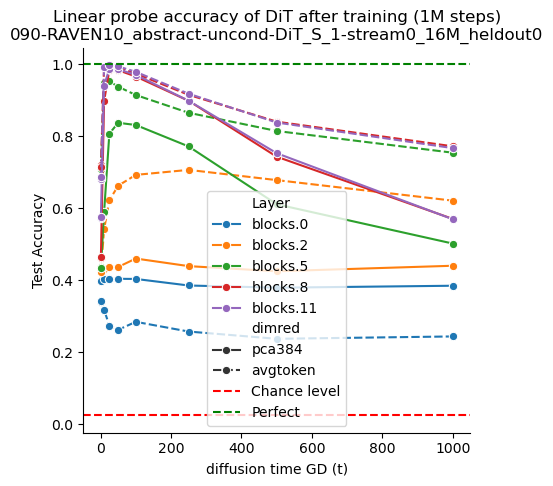

In [110]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[syn_df_DiT.epoch==1000000], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='best')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_alldimred_EMA", figh)

The first two dots were t=0 and t=1 which maybe weird due to lack of training? / too close to the clean image 

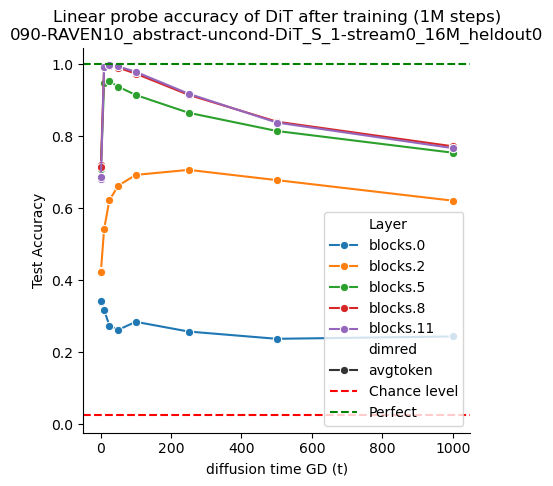

In [109]:
# syn_df_DiT.plot(x="t", y="Test Accuracy", hue="Layer", marker="o") # style=, 
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==1000000) & (syn_df_DiT.dimred=="avgtoken")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_avgtoken_EMA", figh)

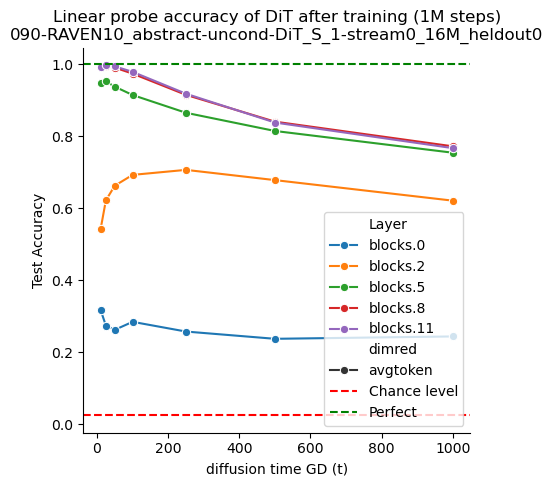

In [108]:
# syn_df_DiT.plot(x="t", y="Test Accuracy", hue="Layer", marker="o") # style=, 
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==1000000) & (syn_df_DiT.dimred=="avgtoken") & (syn_df_DiT.t > 1)], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_avgtoken_EMA_clip1", figh)

### Scaling with training time

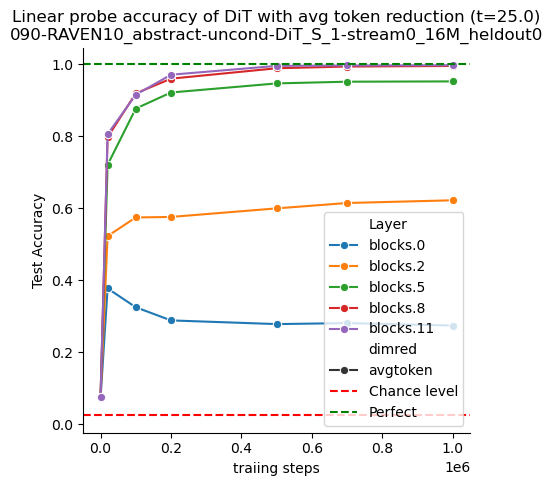

In [99]:
t_scalar = 25.0
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="avgtoken")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of DiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_avgtoken_EMA", figh)
plt.show()

### Scaling with layer depth

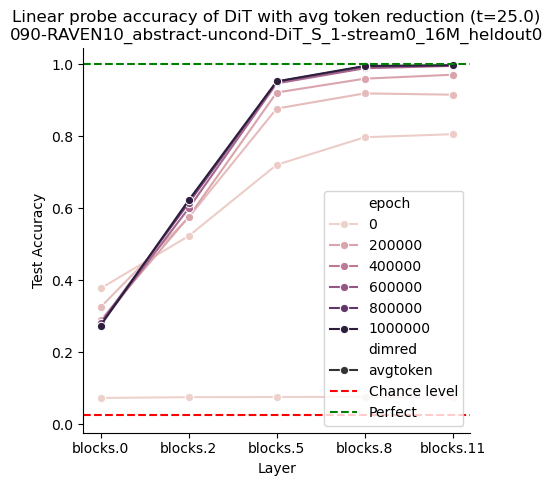

In [100]:
t_scalar = 25.0
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="avgtoken")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of DiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_avgtoken_EMA", figh)

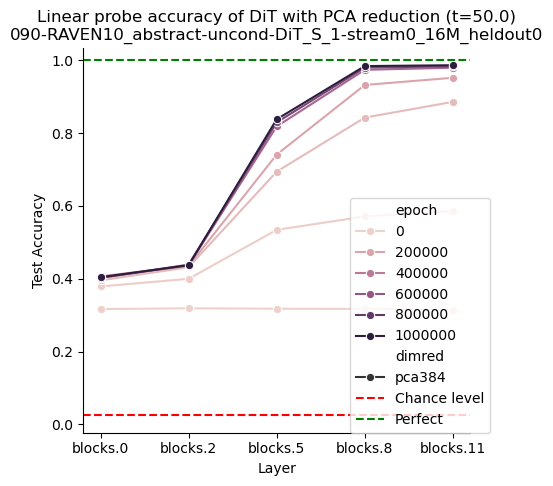

In [106]:
t_scalar = 50.0
figh = plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="pca384")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of DiT with PCA reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
# put legend outside
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.0), borderaxespad=0.)
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_pca384_EMA", figh)

### Error splitting plot 

In [111]:
from matplotlib.patches import Rectangle

def visualize_cm(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    add_rectangles(heldout_rules)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

In [ ]:
results_col['blocks.0']['pred_cls']

tensor([32,  0, 19,  ..., 39, 39, 39], device='cuda:0')

In [112]:
!ls {repr_dir}/results_col_t25_0_avgtoken_ckpt1000000.pkl

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0020000EMA.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0020000.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0100000EMA.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0100000.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_202407

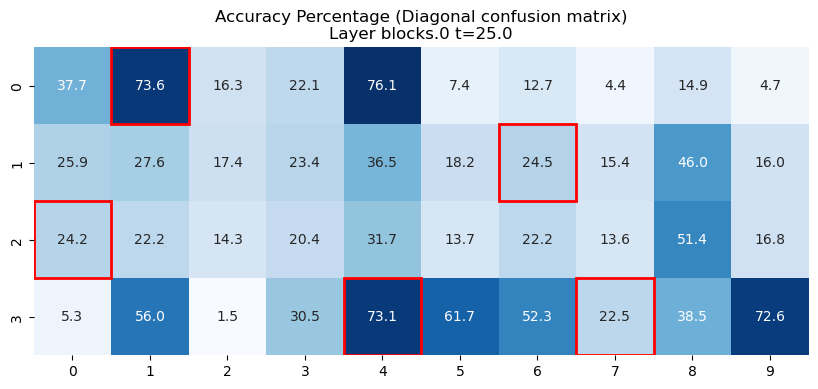

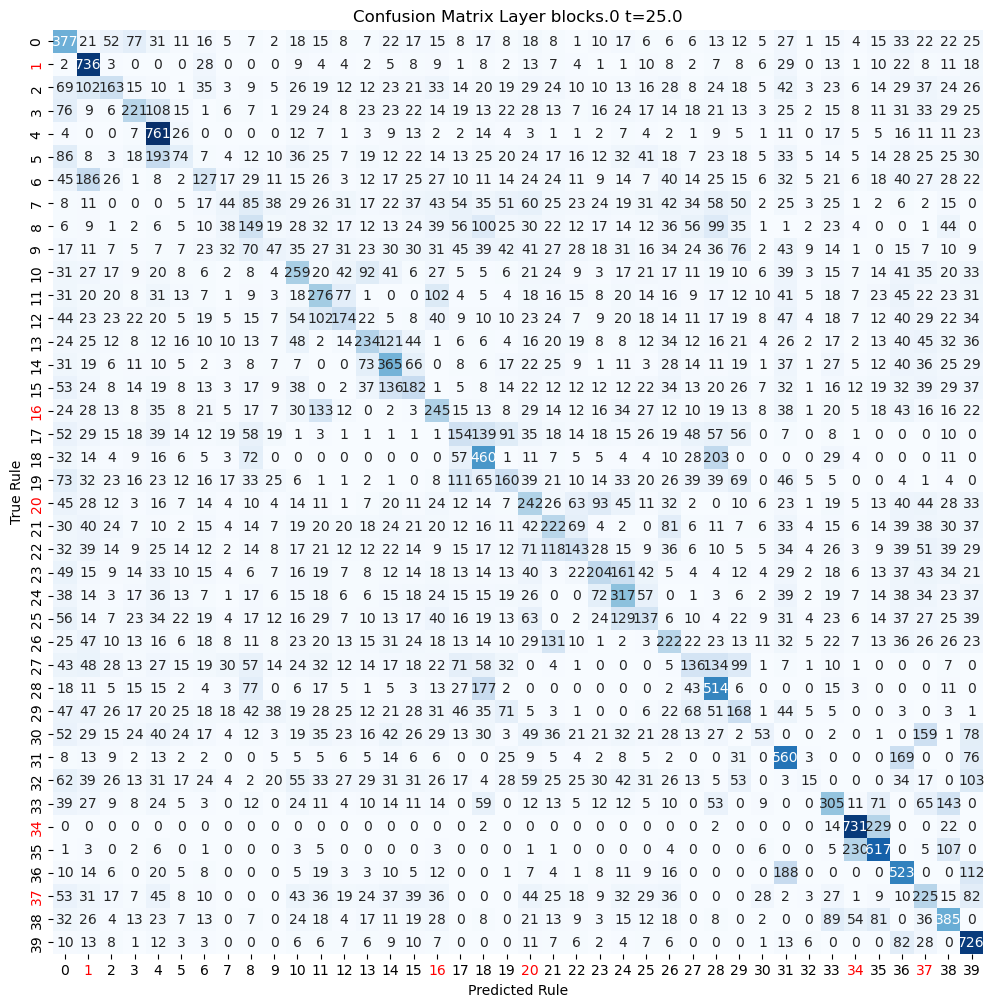

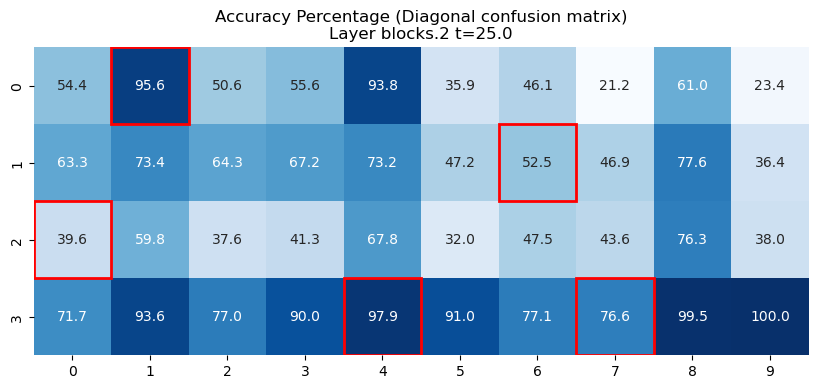

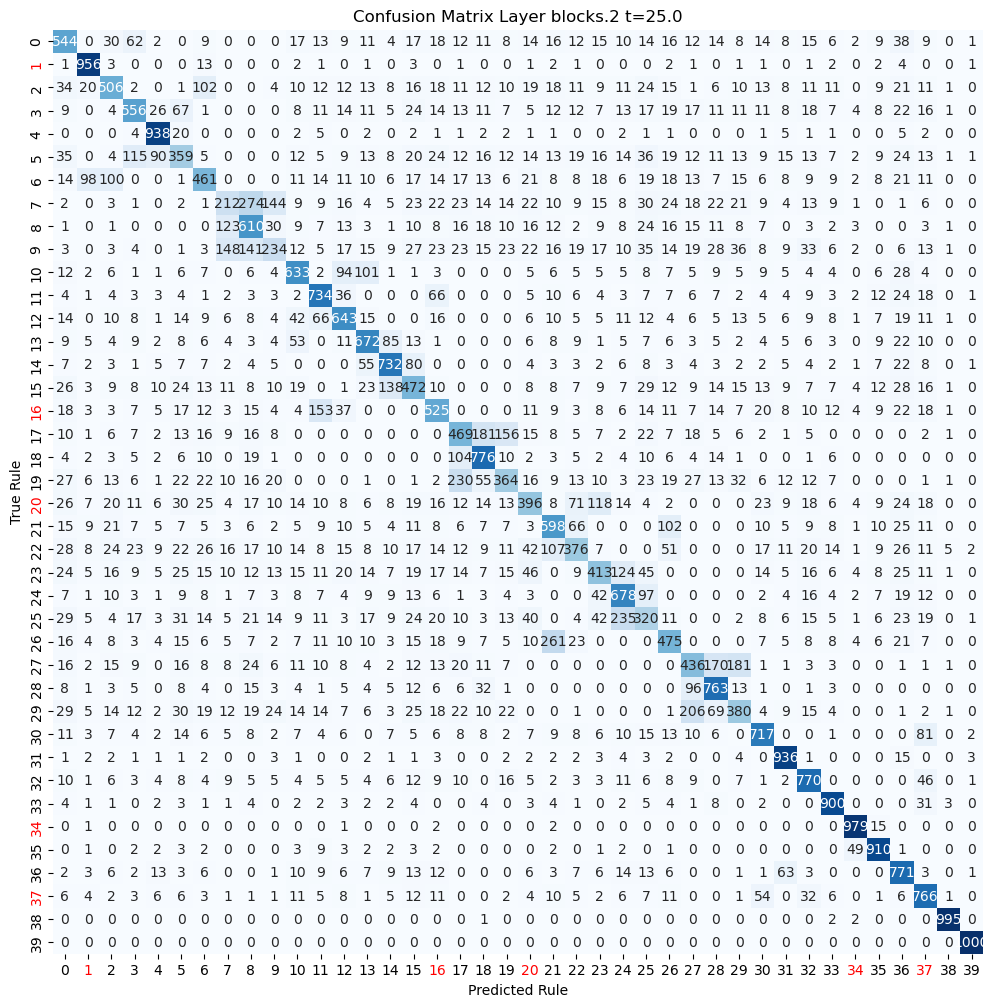

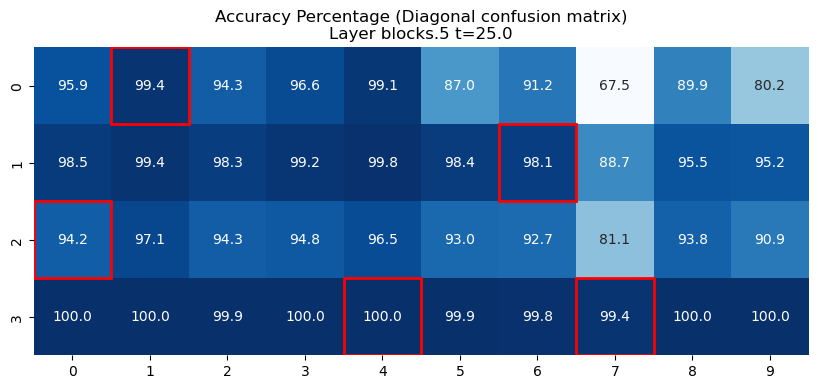

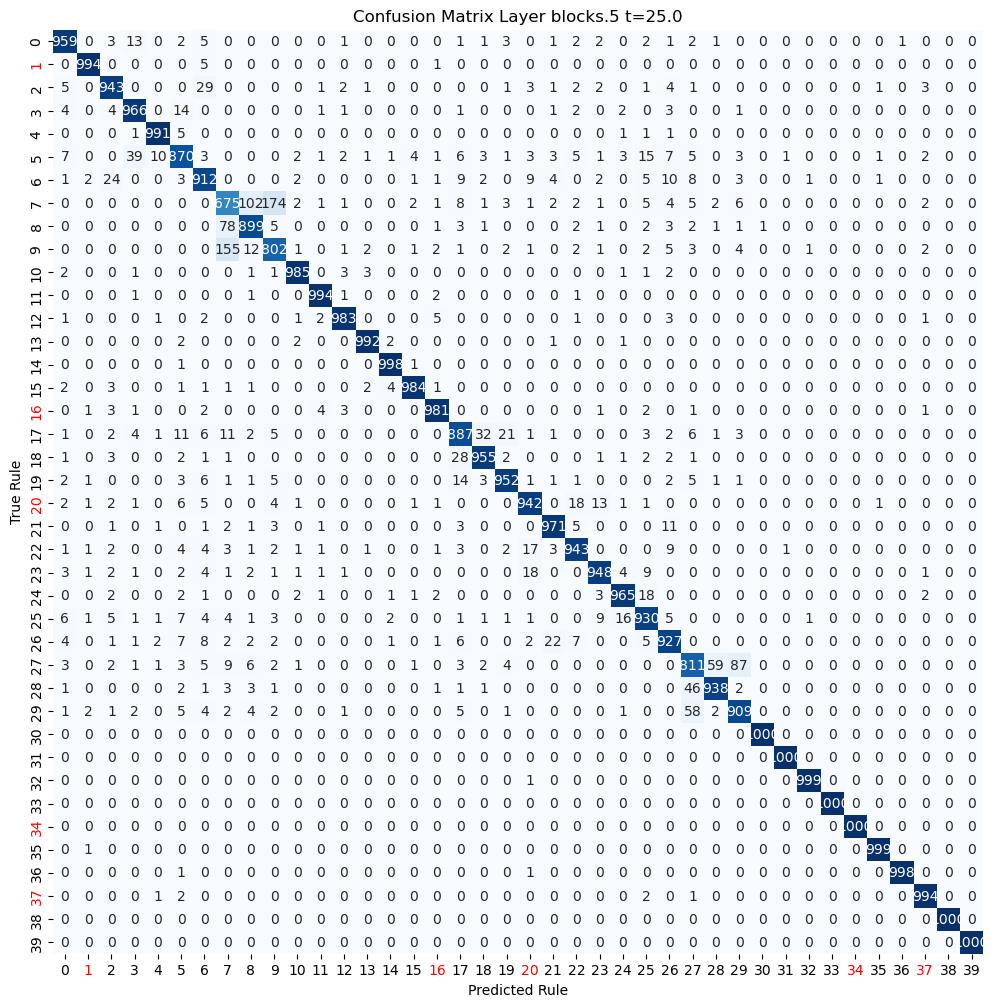

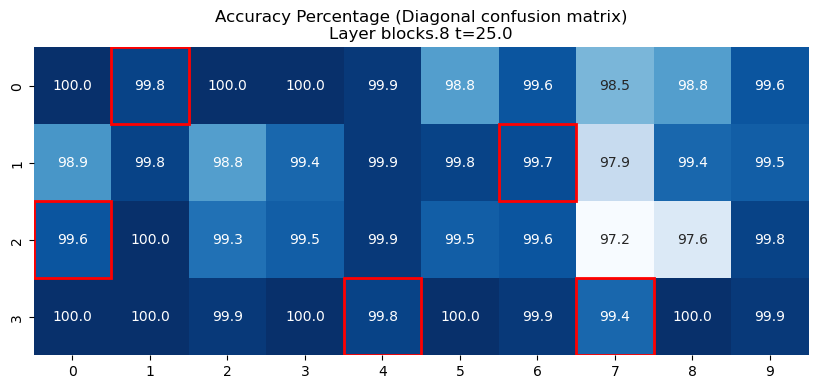

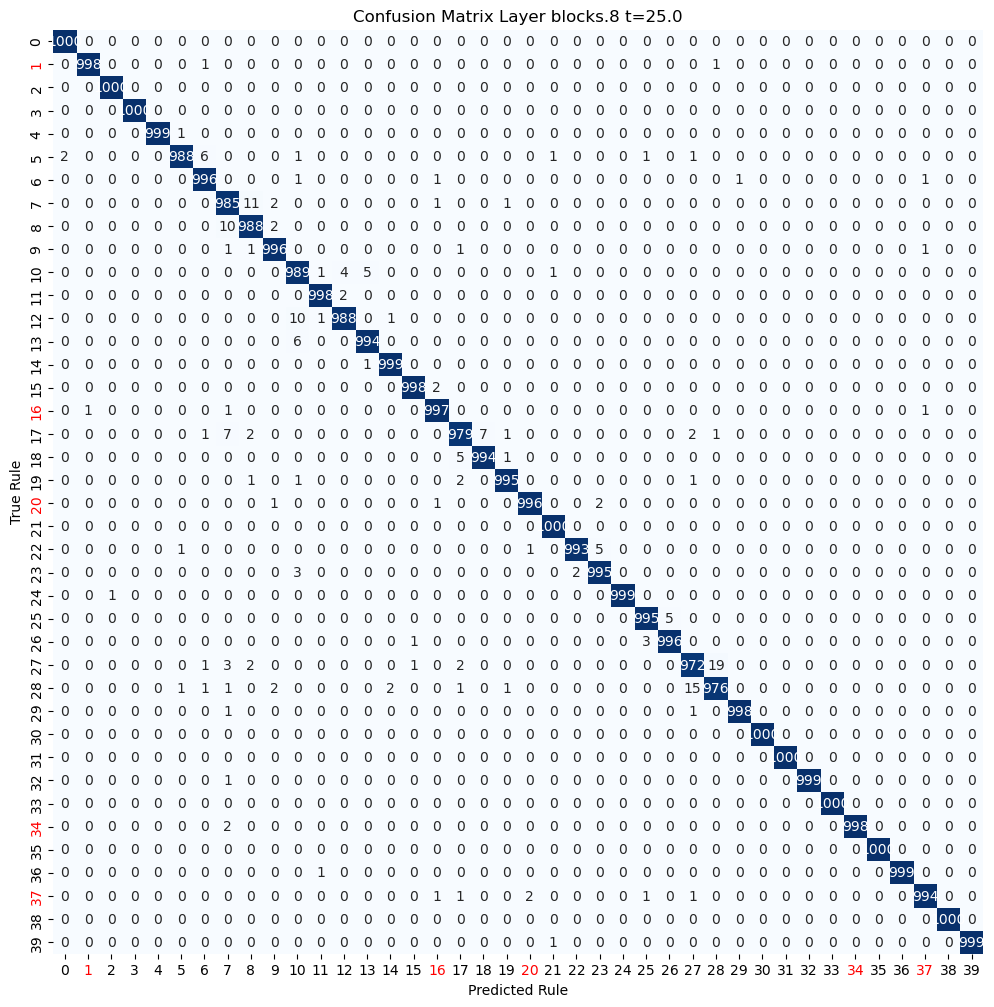

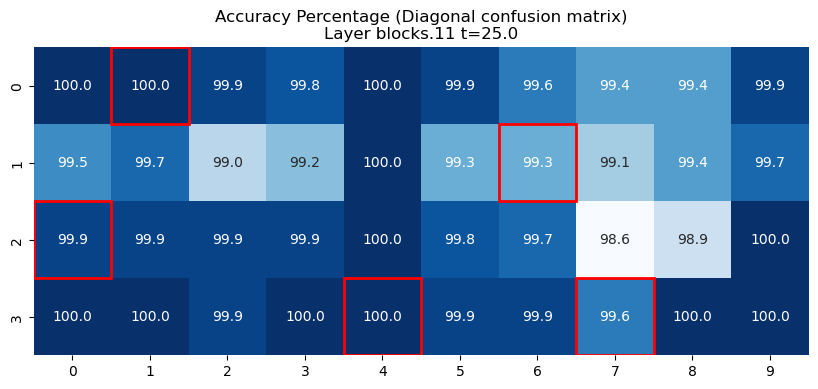

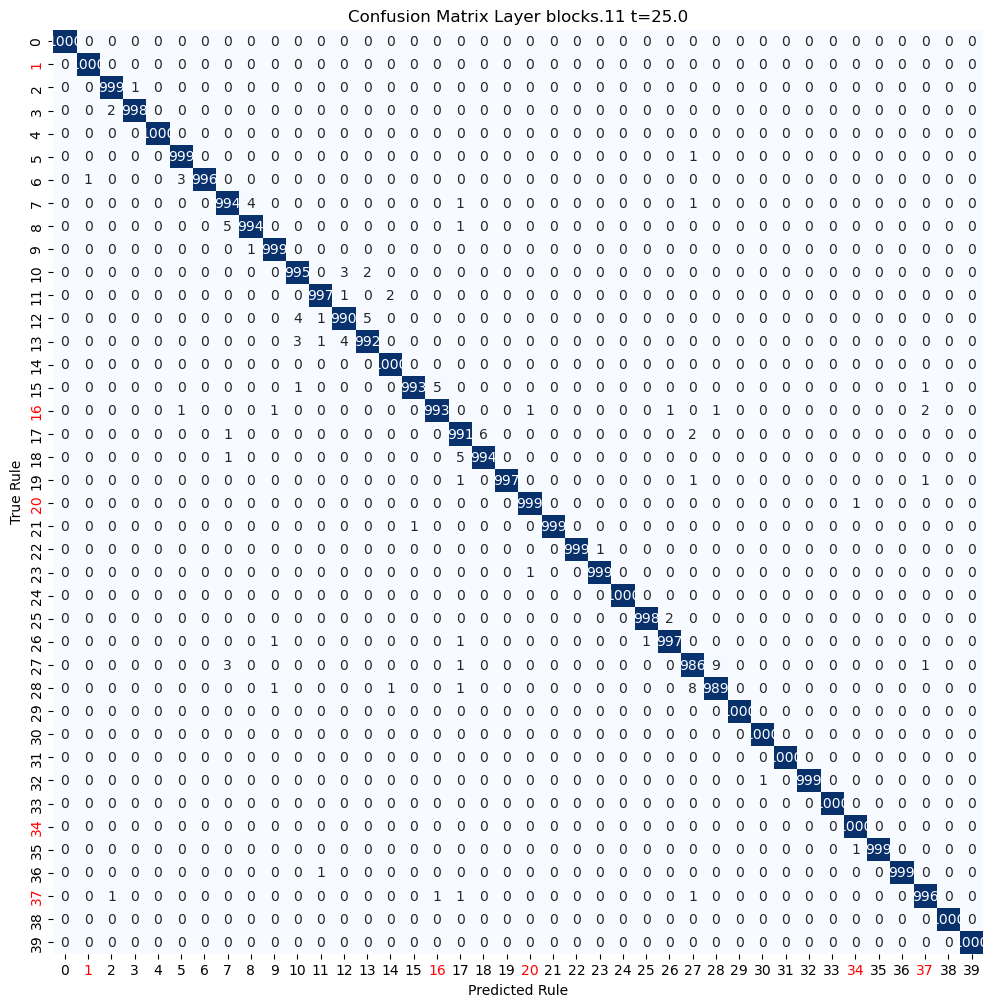

ValueError: Stop here

In [115]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt1000000.pkl"), "rb"))
    for key in results_col.keys():
        pred_cls = results_col[key]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar}")
    raise ValueError("Stop here")

In [23]:
syn_df_DiT

Layer  Test Accuracy  Train Accuracy       t    epoch    dimred
0    blocks.0       0.312450        0.356092     0.0       -1    pca384
1    blocks.2       0.311175        0.356267     0.0       -1    pca384
2    blocks.5       0.315100        0.358700     0.0       -1    pca384
3    blocks.8       0.313800        0.356242     0.0       -1    pca384
4   blocks.11       0.316350        0.359633     0.0       -1    pca384
..        ...            ...             ...     ...      ...       ...
0    blocks.0       0.263075        0.267492  1000.0  1000000  avgtoken
1    blocks.2       0.616650        0.629250  1000.0  1000000  avgtoken
2    blocks.5       0.742375        0.765525  1000.0  1000000  avgtoken
3    blocks.8       0.759375        0.782525  1000.0  1000000  avgtoken
4   blocks.11       0.756300        0.777467  1000.0  1000000  avgtoken

[630 rows x 6 columns]

<Axes: xlabel='t', ylabel='Test Accuracy'>

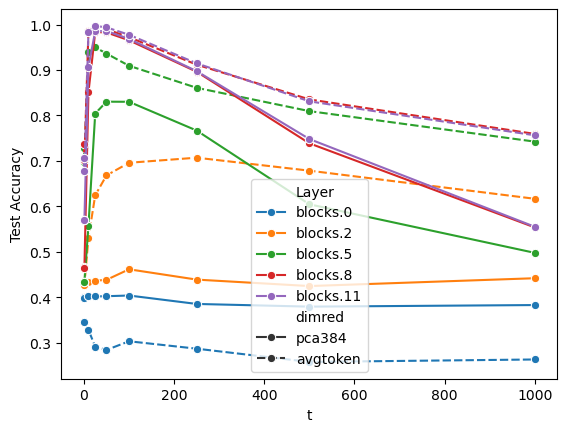

In [28]:
# syn_df_DiT.plot(x="t", y="Test Accuracy", hue="Layer", marker="o") # style=, 
sns.lineplot(data=syn_df_DiT[syn_df_DiT.epoch==1000000], x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")

<Axes: xlabel='epoch', ylabel='Test Accuracy'>

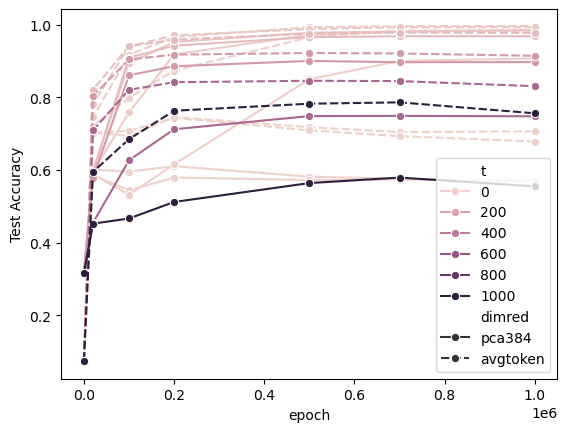

In [29]:
# syn_df_DiT.plot(x="t", y="Test Accuracy", hue="Layer", marker="o") # style=, 
sns.lineplot(data=syn_df_DiT[syn_df_DiT.Layer=="blocks.11"], x="epoch", y="Test Accuracy", hue="t", marker="o", style="dimred")

In [5]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")

syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], epoch_list=[-1, 1000000], PCdim=1024)

FileNotFoundError: [Errno 2] No such file or directory: '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/repr_classifier/results_col_t0_02_PC1024_ckptRNDINIT.pkl'

In [5]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
# state_dict = th.load(ckpt_path, )
# model.load_state_dict(state_dict["model"])
# model.to("cuda").eval();

In [6]:
!ls {ckptdir}

0020000.pt  0200000.pt	0380000.pt  0560000.pt	0740000.pt  0920000.pt
0040000.pt  0220000.pt	0400000.pt  0580000.pt	0760000.pt  0940000.pt
0060000.pt  0240000.pt	0420000.pt  0600000.pt	0780000.pt  0960000.pt
0080000.pt  0260000.pt	0440000.pt  0620000.pt	0800000.pt  0980000.pt
0100000.pt  0280000.pt	0460000.pt  0640000.pt	0820000.pt  1000000.pt
0120000.pt  0300000.pt	0480000.pt  0660000.pt	0840000.pt
0140000.pt  0320000.pt	0500000.pt  0680000.pt	0860000.pt
0160000.pt  0340000.pt	0520000.pt  0700000.pt	0880000.pt
0180000.pt  0360000.pt	0540000.pt  0720000.pt	0900000.pt


In [8]:
!ls {repr_dir}

model_PCA_col_PC1024.pkl
model_PCA_col_PC2048.pkl
model_PCA_col_PC512.pkl
model_PCA_col_t0_02_PC1024.pkl
model_PCA_col_t0_05_PC1024.pkl
model_PCA_col_t0_1_PC1024ckpt0020000EMA.pkl
model_PCA_col_t0_1_PC1024ckpt0020000.pkl
model_PCA_col_t0_1_PC1024ckpt1000000EMA.pkl
model_PCA_col_t0_1_PC1024ckpt1000000.pkl
model_PCA_col_t0_1_PC1024ckptRNDINIT.pkl
model_PCA_col_t0_1_PC1024.pkl
model_PCA_col_t0_1_PCFULLckpt0020000.pkl
model_PCA_col_t0_1_PCFULLckpt0100000.pkl
model_PCA_col_t0_1_PCFULLckpt1000000.pkl
model_PCA_col_t0_1_PCFULLckptRNDINIT.pkl
model_PCA_col_t0_3_PC1024.pkl
model_PCA_col_t0_5_PC1024.pkl
model_PCA_col_t0_7_PC1024.pkl
model_PCA_col_t0_9_PC1024.pkl
model_PCA_col_t1_0_PC1024.pkl
PC_proj_col_PC1024.pkl
PC_proj_col_PC2048.pkl
PC_proj_col_PC512.pkl
PC_proj_col_t0_02_PC1024.pkl
PC_proj_col_t0_05_PC1024.pkl
PC_proj_col_t0_1_PC1024ckpt0020000EMA.pkl
PC_proj_col_t0_1_PC1024ckpt0020000.pkl
PC_proj_col_t0_1_PC1024ckpt1000000EMA.pkl
PC_proj_col_t0_1_PC1024ckpt1000000.pkl
PC_proj_col_t0_1_PC10

### Synthesize Classification accuracy across time

In [11]:
syn_df_all = []
t_scalar = 0.1
for PCdim in [1024, ]:
    for t_scalar in [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        t_str = str(t_scalar).replace(".", "_")
        results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC{PCdim}.pkl"), "rb"))
        test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["t"] = t_scalar
        syn_df["PCdim"] = PCdim
        # drop index as layer name
        syn_df = syn_df.reset_index()
        syn_df = syn_df.rename(columns={"index": "Layer"})
        syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

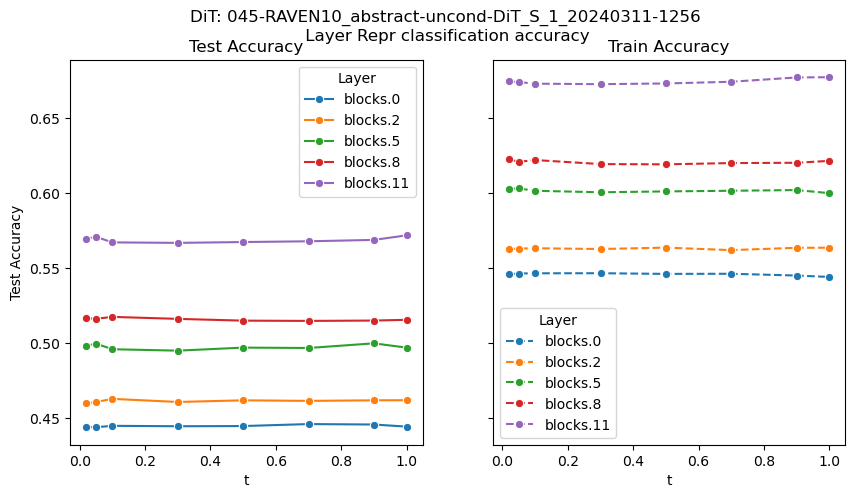

In [12]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all, x="t", y="Test Accuracy", hue="Layer", marker="o")
plt.title(f"Test Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all, x="t", y="Train Accuracy", hue="Layer", marker="o", linestyle="--")
plt.title(f"Train Accuracy")
plt.suptitle(f"DiT: {expname}\n Layer Repr classification accuracy")
plt.show()

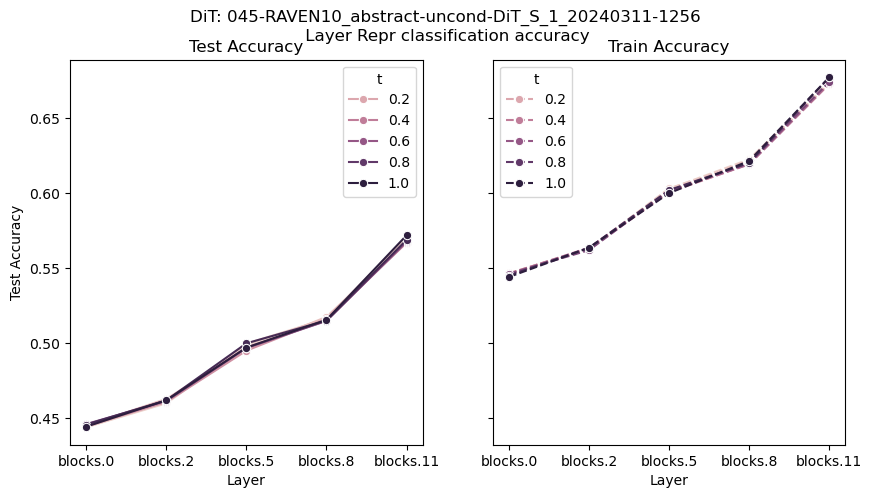

In [13]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="t", marker="o")
plt.title(f"Test Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all, x="Layer", y="Train Accuracy", hue="t", marker="o", linestyle="--")
plt.title(f"Train Accuracy")
plt.suptitle(f"DiT: {expname}\n Layer Repr classification accuracy")
plt.show()

In [46]:
for t in [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    syn_df = syn_df_all[syn_df_all["t"]==t]
    print(f"t={t}")
    print(syn_df)

t=0.02
       Layer  Test Accuracy  Train Accuracy     t
0   blocks.0       0.444175        0.545925  0.02
1   blocks.2       0.460025        0.562658  0.02
2   blocks.5       0.498350        0.602717  0.02
3   blocks.8       0.516600        0.622467  0.02
4  blocks.11       0.569600        0.674267  0.02
t=0.05
       Layer  Test Accuracy  Train Accuracy     t
0   blocks.0       0.444125        0.546400  0.05
1   blocks.2       0.460900        0.563008  0.05
2   blocks.5       0.499700        0.603025  0.05
3   blocks.8       0.516300        0.620725  0.05
4  blocks.11       0.570775        0.673783  0.05
t=0.1
       Layer  Test Accuracy  Train Accuracy    t
0   blocks.0       0.445050        0.546550  0.1
1   blocks.2       0.463000        0.563225  0.1
2   blocks.5       0.496025        0.601467  0.1
3   blocks.8       0.517550        0.621917  0.1
4  blocks.11       0.567125        0.672733  0.1
t=0.3
       Layer  Test Accuracy  Train Accuracy    t
0   blocks.0       0.444775    

### Synthesize Classification accuracy through the training process

In [48]:
!cd {exproot}; ls -d 075*

075-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243


In [16]:
!ls {repr_dir}

model_PCA_col_t0_1_PC1024ckpt0020000.pkl
model_PCA_col_t0_1_PC1024ckpt0100000.pkl
model_PCA_col_t0_1_PC1024ckpt0200000.pkl
model_PCA_col_t0_1_PC1024ckpt0500000.pkl
model_PCA_col_t0_1_PC1024ckpt1000000.pkl
model_PCA_col_t0_1_PC1024ckptRNDINIT.pkl
model_PCA_col_t0_1_PCFULLckpt0020000.pkl
model_PCA_col_t0_1_PCFULLckpt0100000.pkl
model_PCA_col_t0_1_PCFULLckpt0200000.pkl
model_PCA_col_t0_1_PCFULLckpt0500000.pkl
model_PCA_col_t0_1_PCFULLckpt1000000.pkl
model_PCA_col_t0_1_PCFULLckptRNDINIT.pkl
PC_proj_col_t0_1_PC1024ckpt0020000.pkl
PC_proj_col_t0_1_PC1024ckpt0100000.pkl
PC_proj_col_t0_1_PC1024ckpt0200000.pkl
PC_proj_col_t0_1_PC1024ckpt0500000.pkl
PC_proj_col_t0_1_PC1024ckpt1000000.pkl
PC_proj_col_t0_1_PC1024ckptRNDINIT.pkl
PC_proj_col_t0_1_PCFULLckpt0020000.pkl
PC_proj_col_t0_1_PCFULLckpt0100000.pkl
PC_proj_col_t0_1_PCFULLckpt0200000.pkl
PC_proj_col_t0_1_PCFULLckpt0500000.pkl
PC_proj_col_t0_1_PCFULLckpt1000000.pkl
PC_proj_col_t0_1_PCFULLckptRNDINIT.pkl
results_col_t0_1_PC1024ckpt0020000.pkl
r

In [15]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"075-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
# ckpt_path = join(ckptdir, "1000000.pt")
# state_dict = th.load(ckpt_path, )
# model.load_state_dict(state_dict["model"])
# model.to("cuda").eval();

In [16]:
syn_df_all = []
t_scalar = 0.1
t_str = str(t_scalar).replace(".", "_")
PCdim = 1024
for PCdim in [1024, "FULL"]:
    for epoch in [0,20000, 100000, 200000, 500000, 1000000]:
        if epoch == 0:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC{PCdim}ckptRNDINIT.pkl"), "rb"))
        else:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC{PCdim}ckpt{epoch:07d}.pkl"), "rb"))
        test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["epoch"] = epoch
        syn_df["PCdim"] = PCdim
        # drop index as layer name
        syn_df = syn_df.reset_index()
        syn_df = syn_df.rename(columns={"index": "Layer"})
        syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

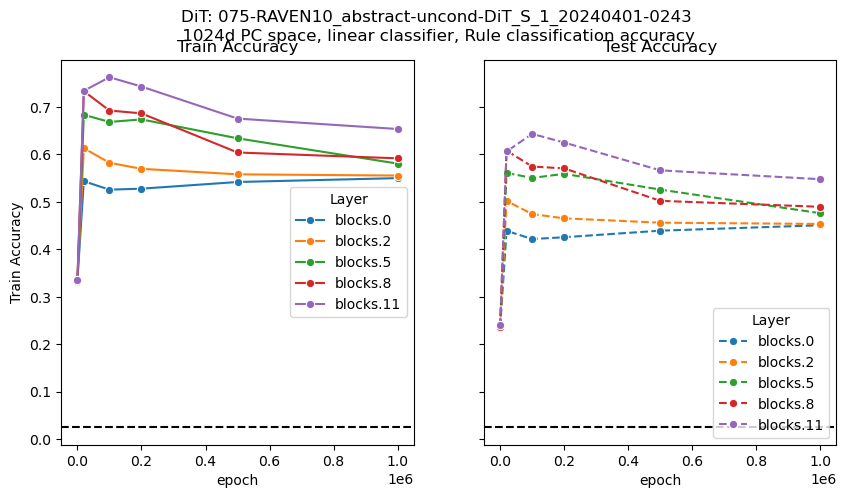

In [17]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Train Accuracy", hue="Layer", marker="o")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Train Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Test Accuracy")
plt.suptitle(f"DiT: {expname}\n 1024d PC space, linear classifier, Rule classification accuracy")
plt.show()

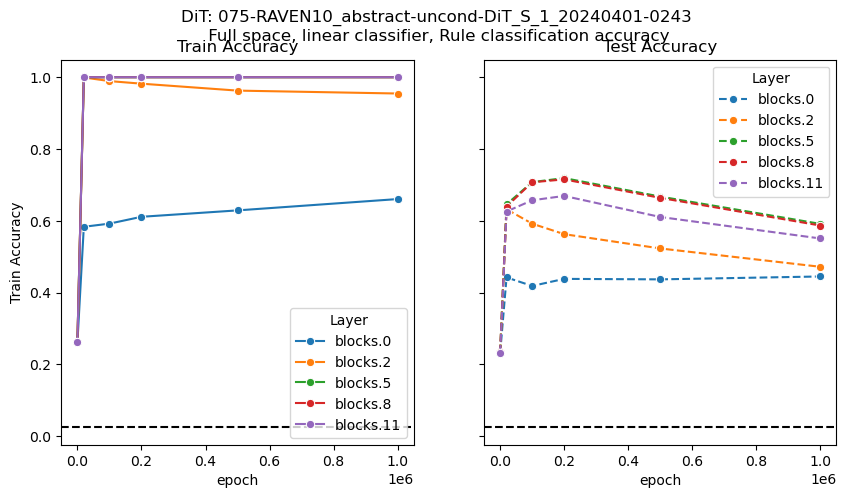

In [18]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Train Accuracy", hue="Layer", marker="o")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Train Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Test Accuracy")
plt.suptitle(f"DiT: {expname}\n Full space, linear classifier, Rule classification accuracy")
plt.show()

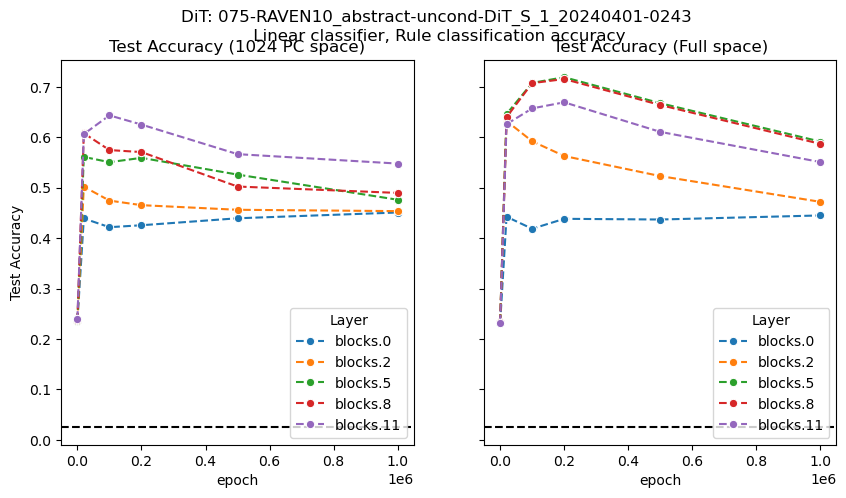

In [19]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
# sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Train Accuracy", hue="Layer", marker="o")
# sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Train Accuracy", hue="Layer", marker="+")
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (1024 PC space)")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (Full space)")
plt.suptitle(f"DiT: {expname}\n Linear classifier, Rule classification accuracy")
plt.show()

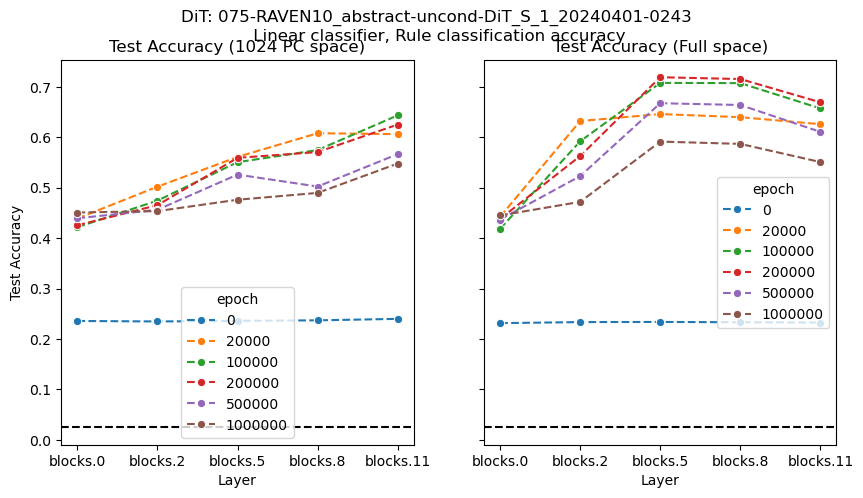

In [21]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="Layer", y="Test Accuracy", hue="epoch", marker="o", linestyle="--", palette="tab10")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (1024 PC space)")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="Layer", y="Test Accuracy", hue="epoch", marker="o", linestyle="--", palette="tab10")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (Full space)")
plt.suptitle(f"DiT: {expname}\n Linear classifier, Rule classification accuracy")
plt.show()

#### Confusion matrix of rule classification based on internal rules

In [21]:
from matplotlib.patches import Rectangle

def visualize_cm(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    for rule_id in heldout_rules:
        row = rule_id // 10
        col = rule_id % 10
        plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

In [37]:
results_col['blocks.0']['pred_cls']

tensor([32,  0, 19,  ..., 39, 39, 39], device='cuda:0')

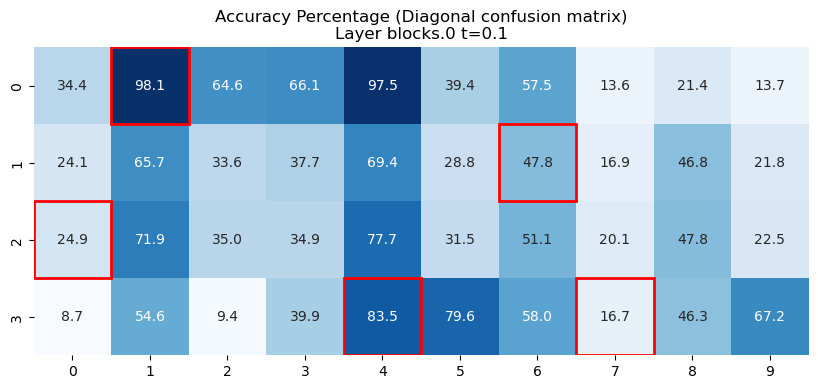

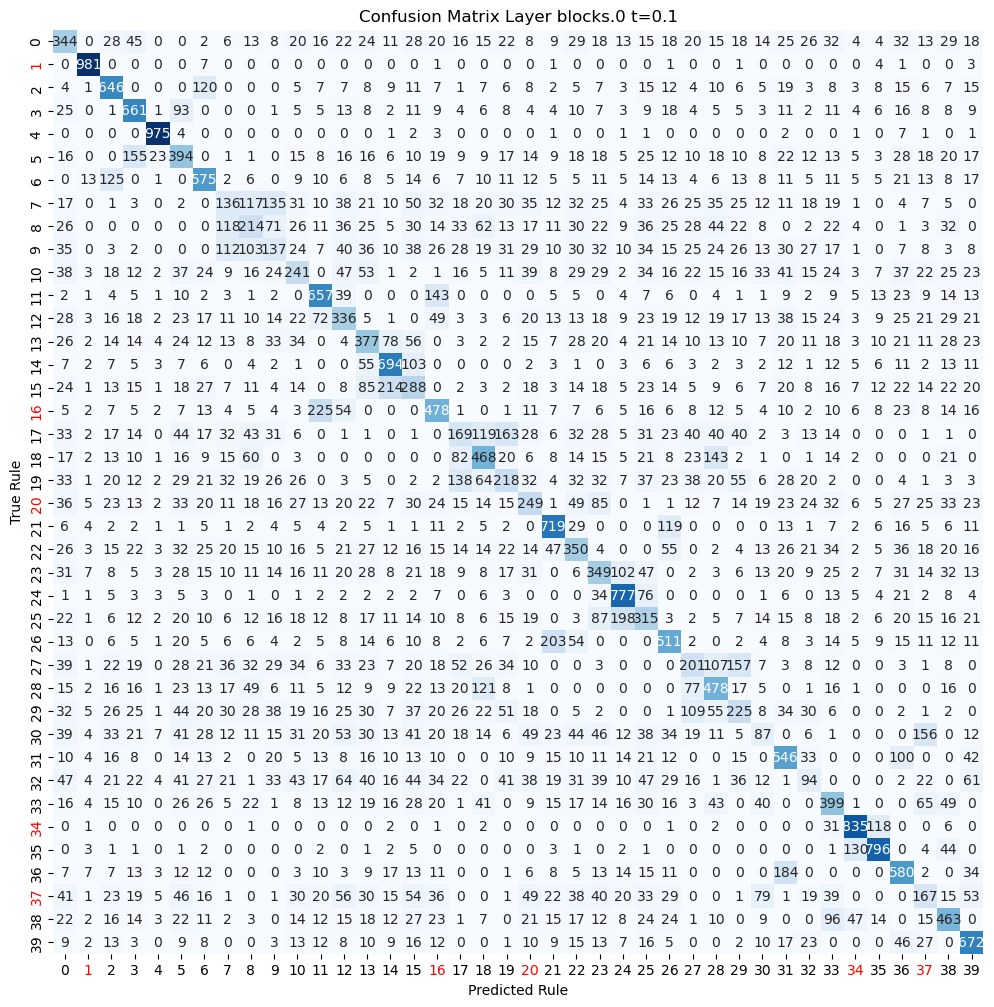

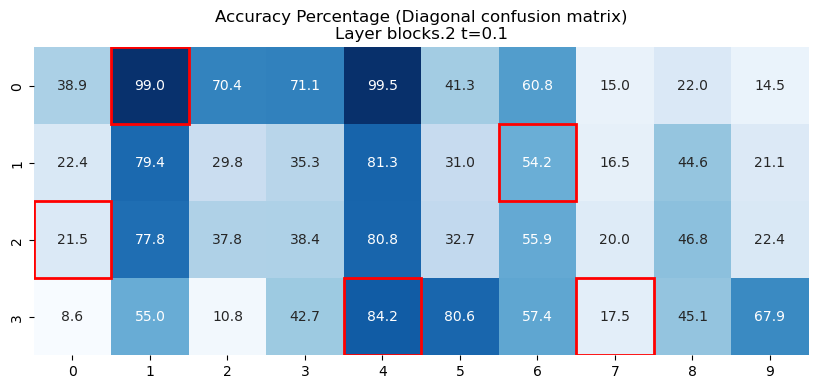

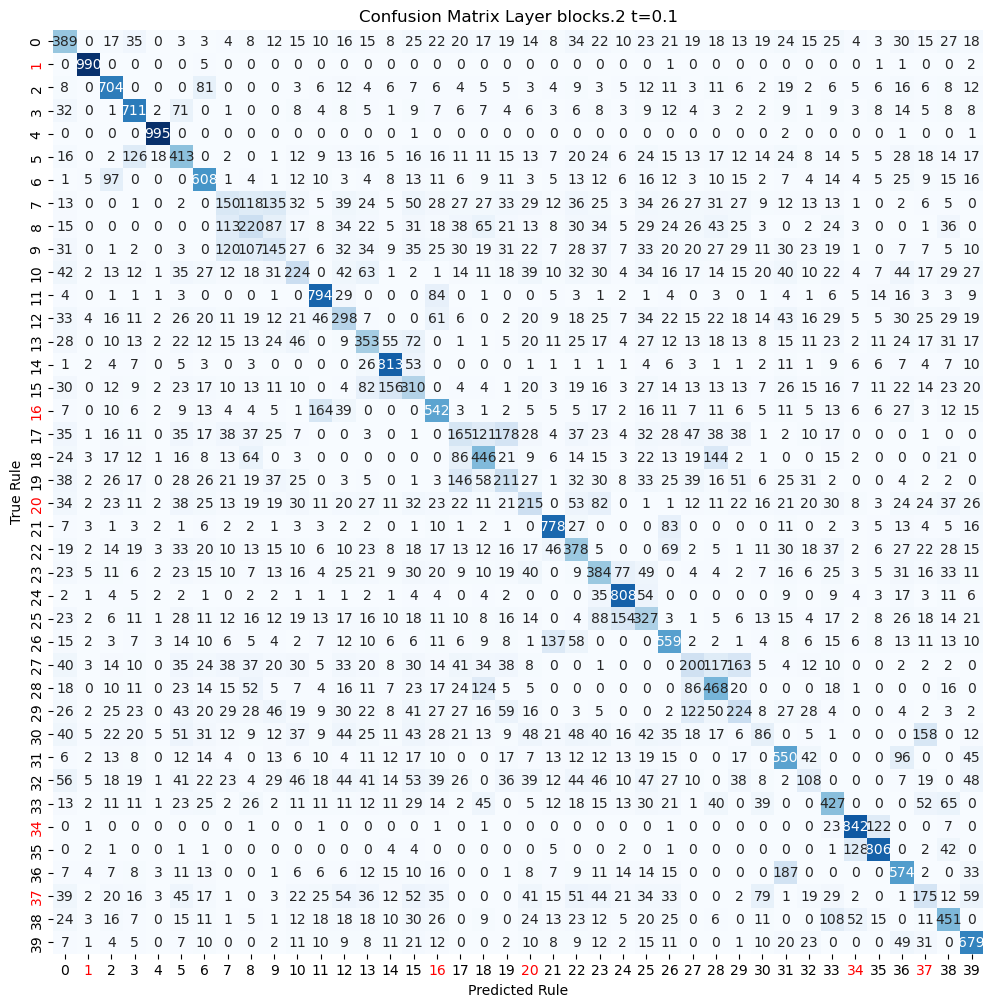

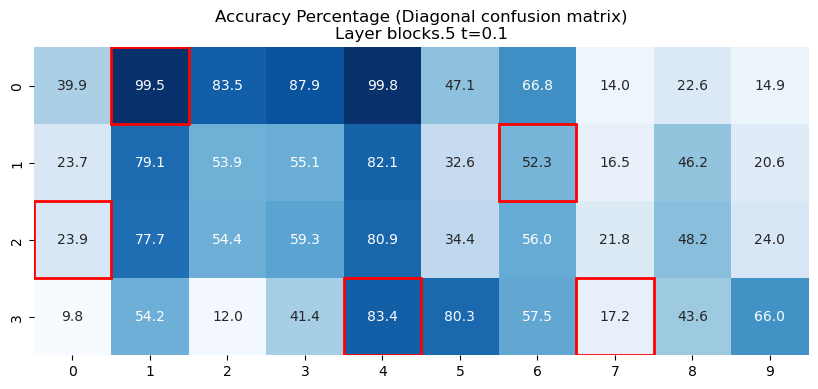

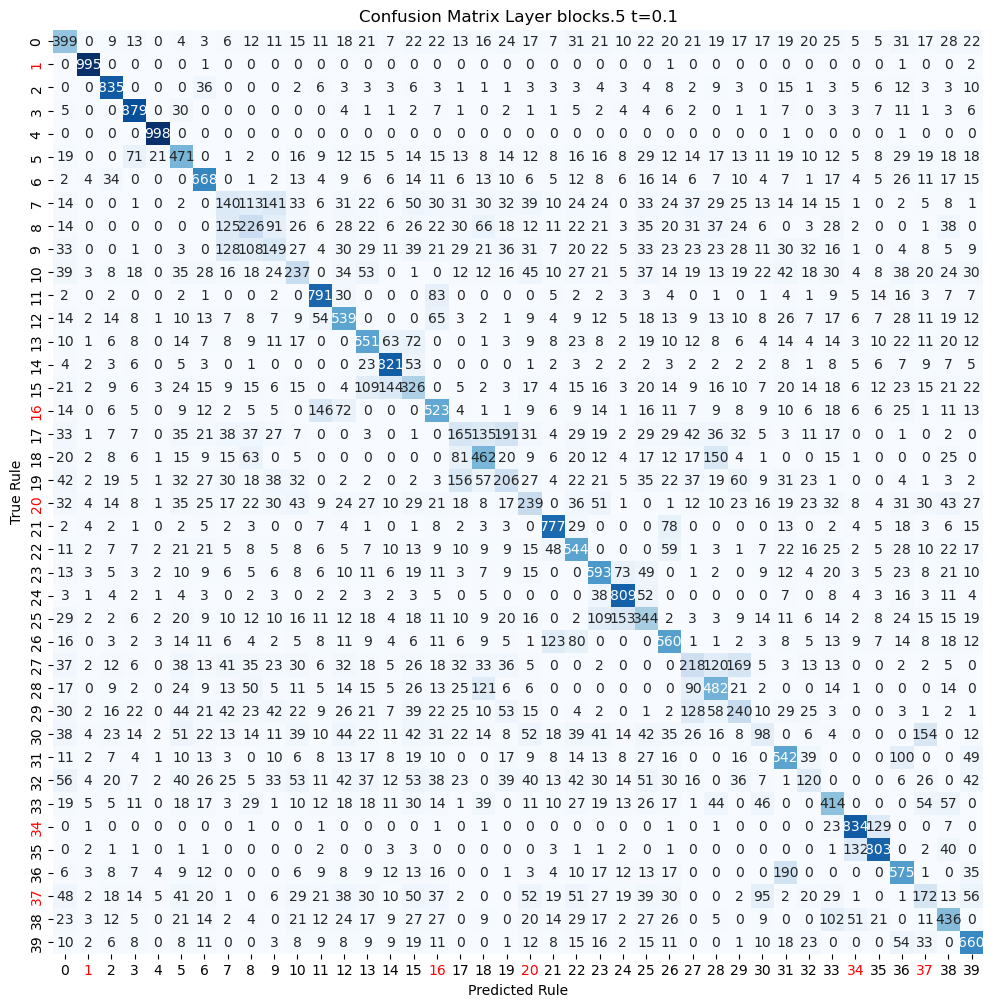

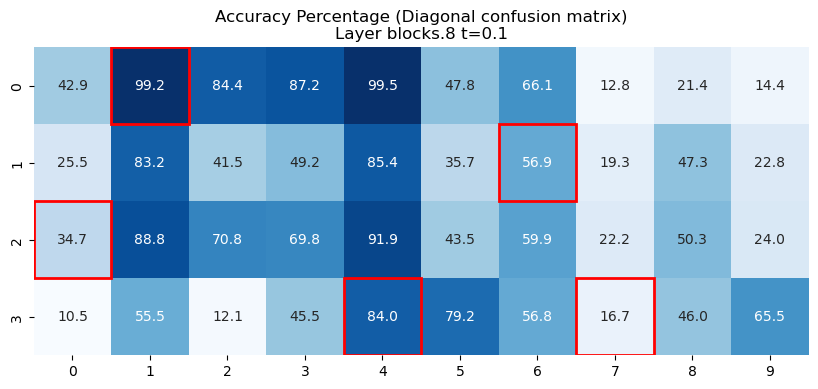

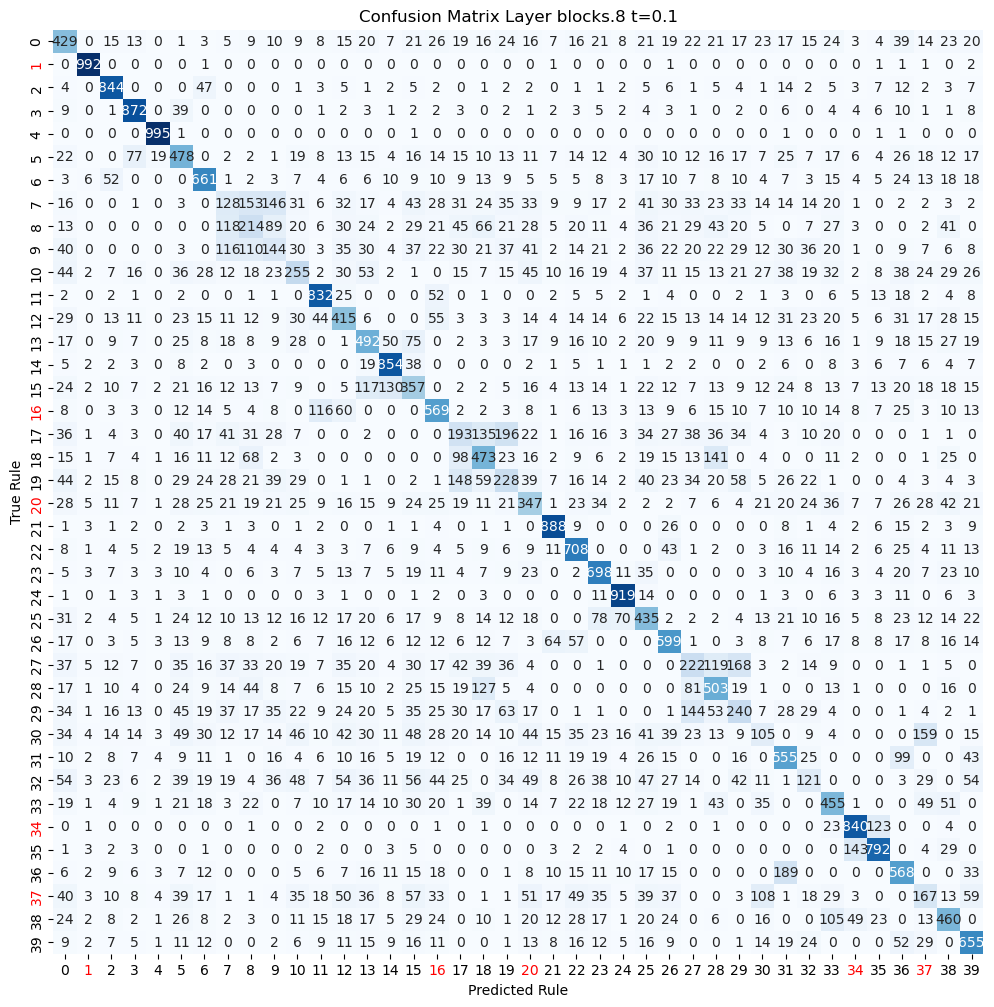

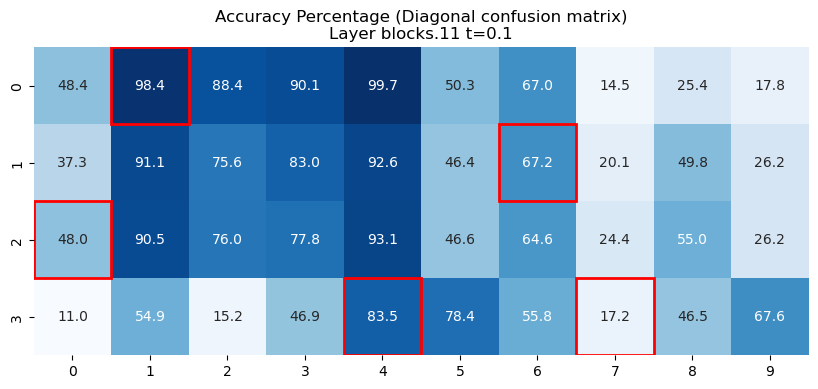

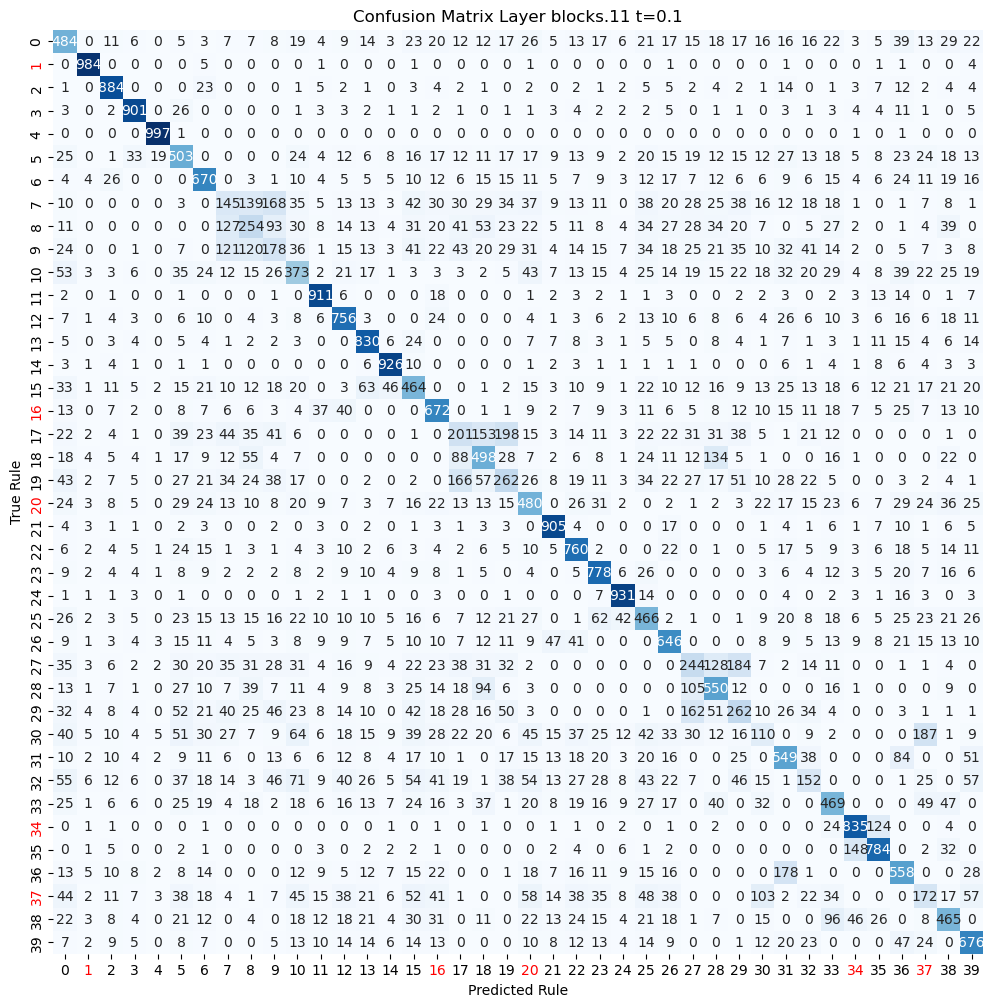

In [10]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
t_scalar = 0.1
for t_scalar in [0.1]:#[0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC1024.pkl"), "rb"))
    for key in results_col.keys():
        pred_cls = results_col[key]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar}")

#### Confusion matrix of relation and rule attr dim

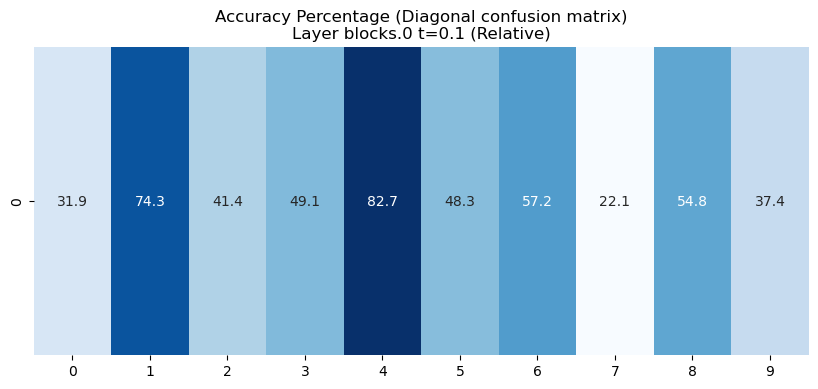

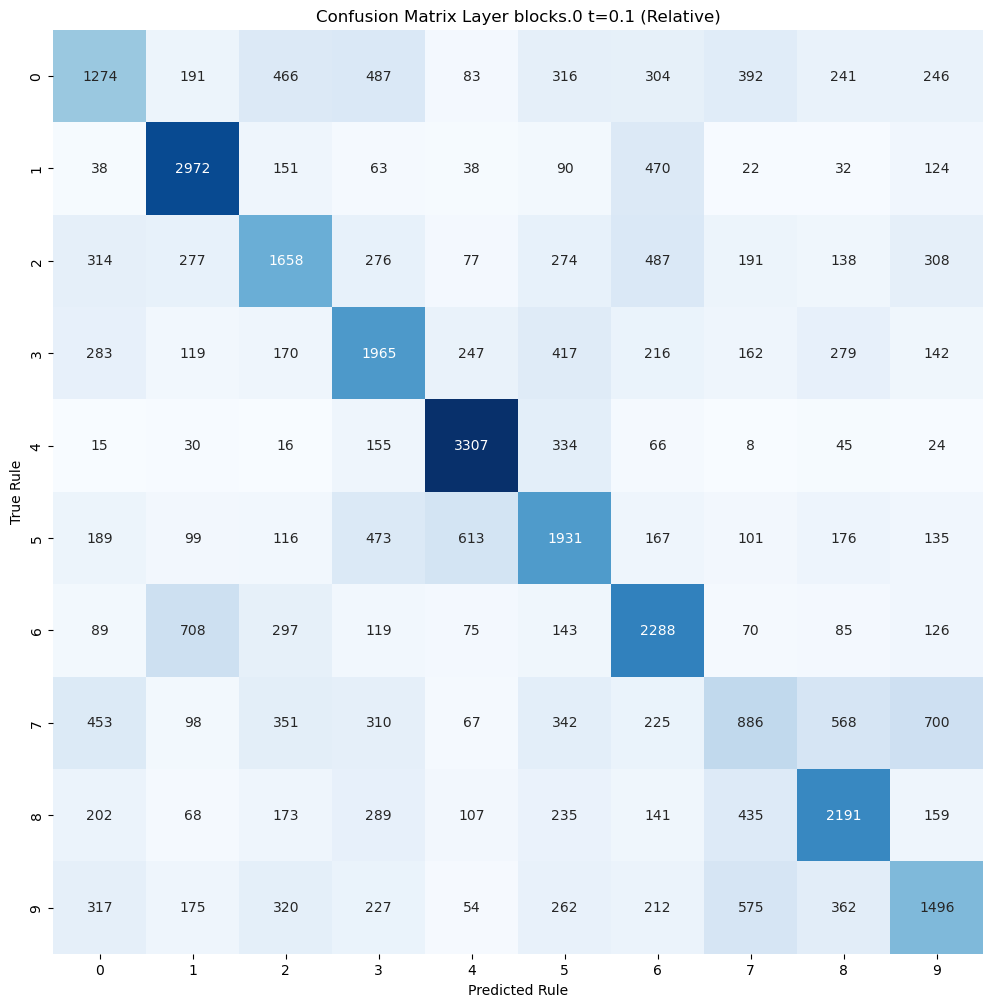

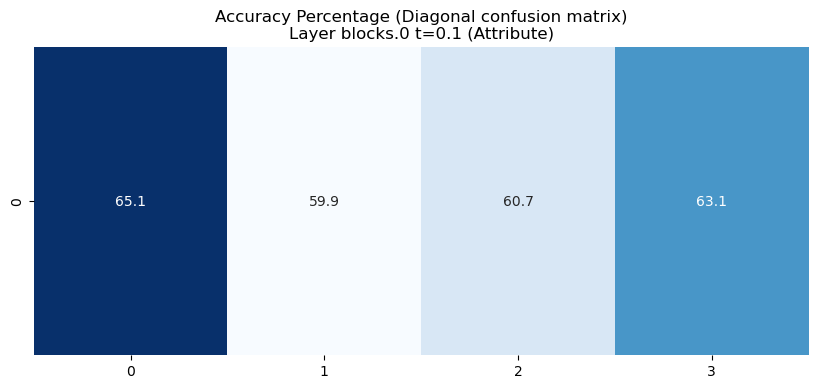

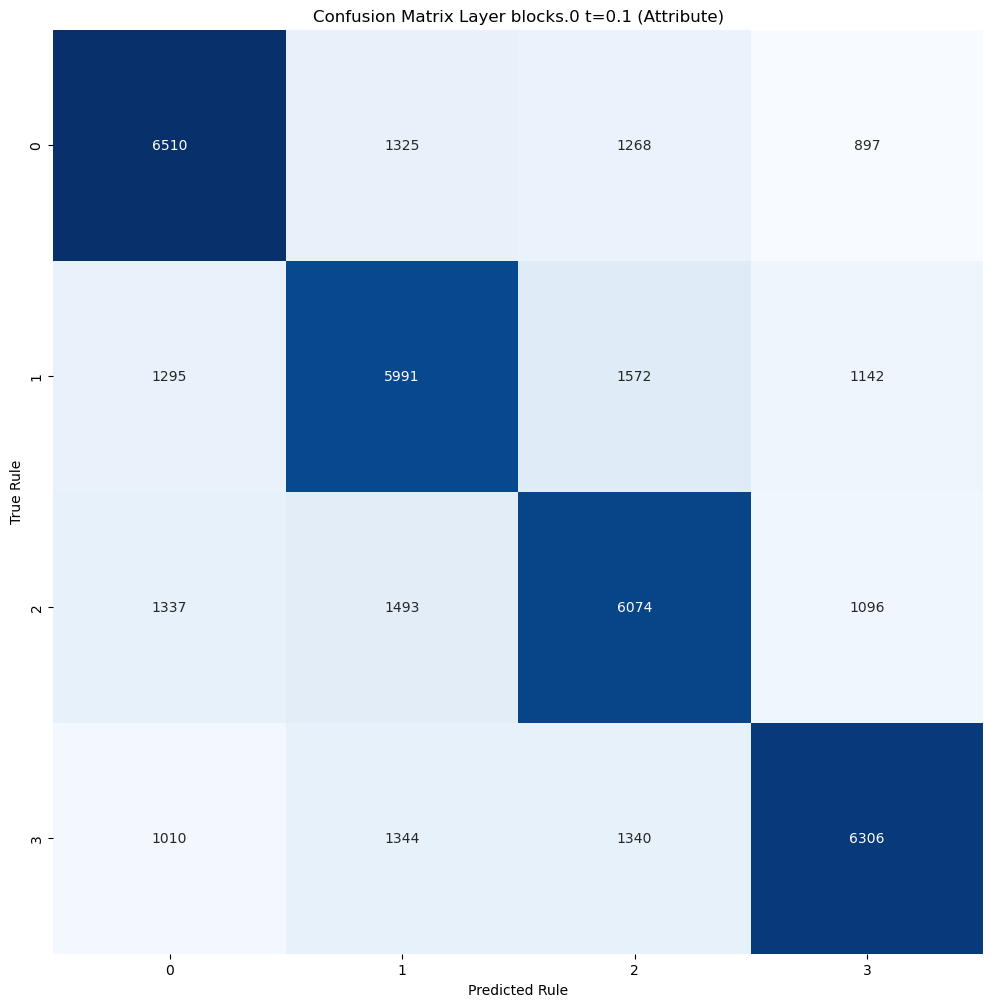

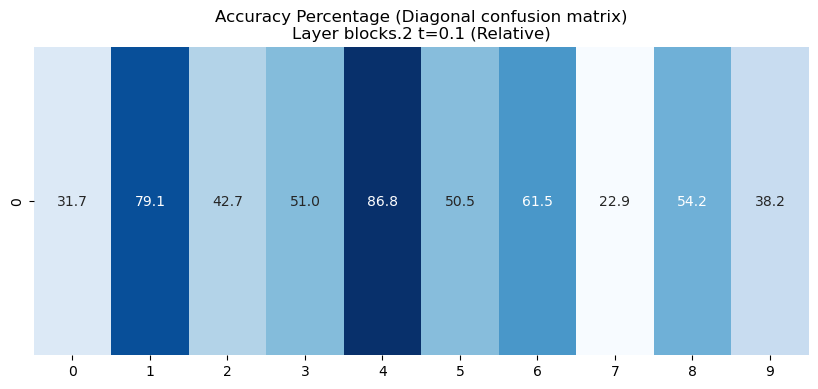

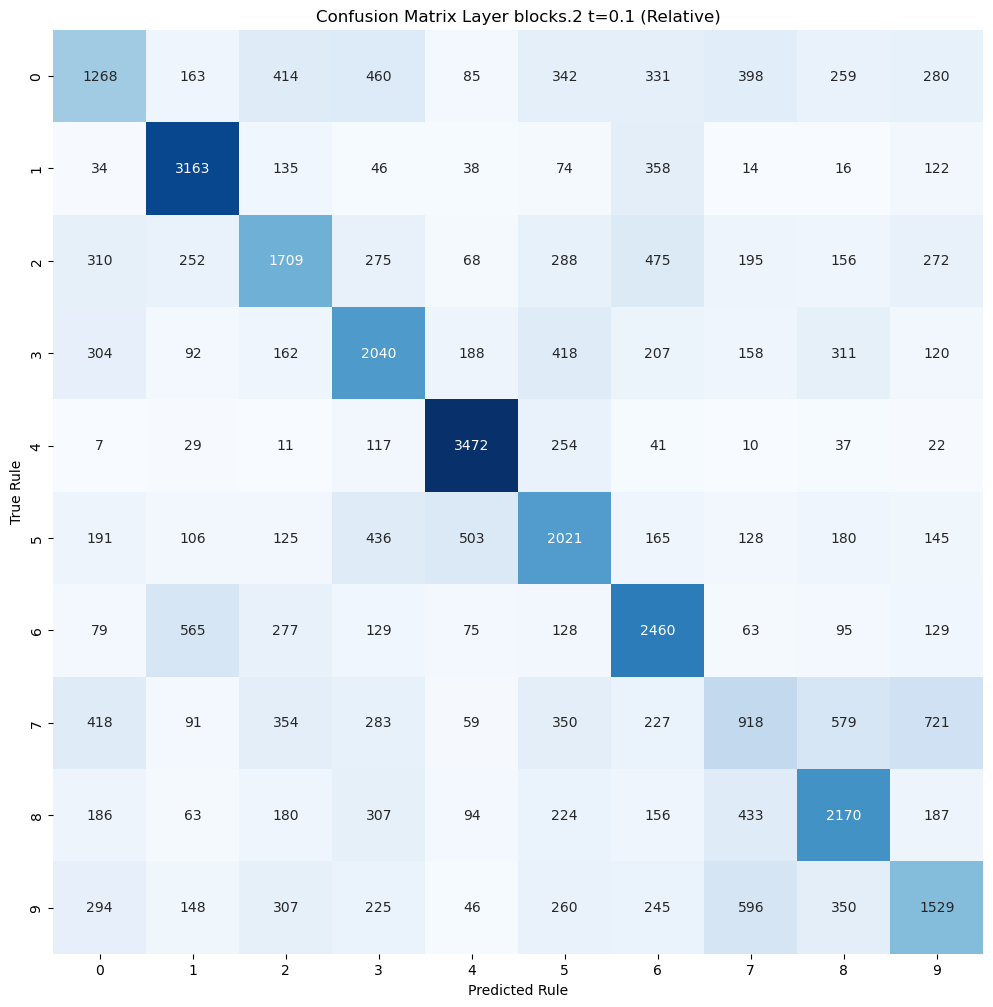

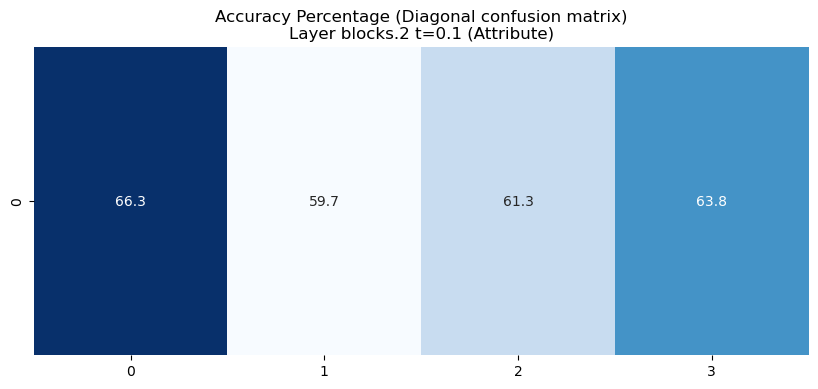

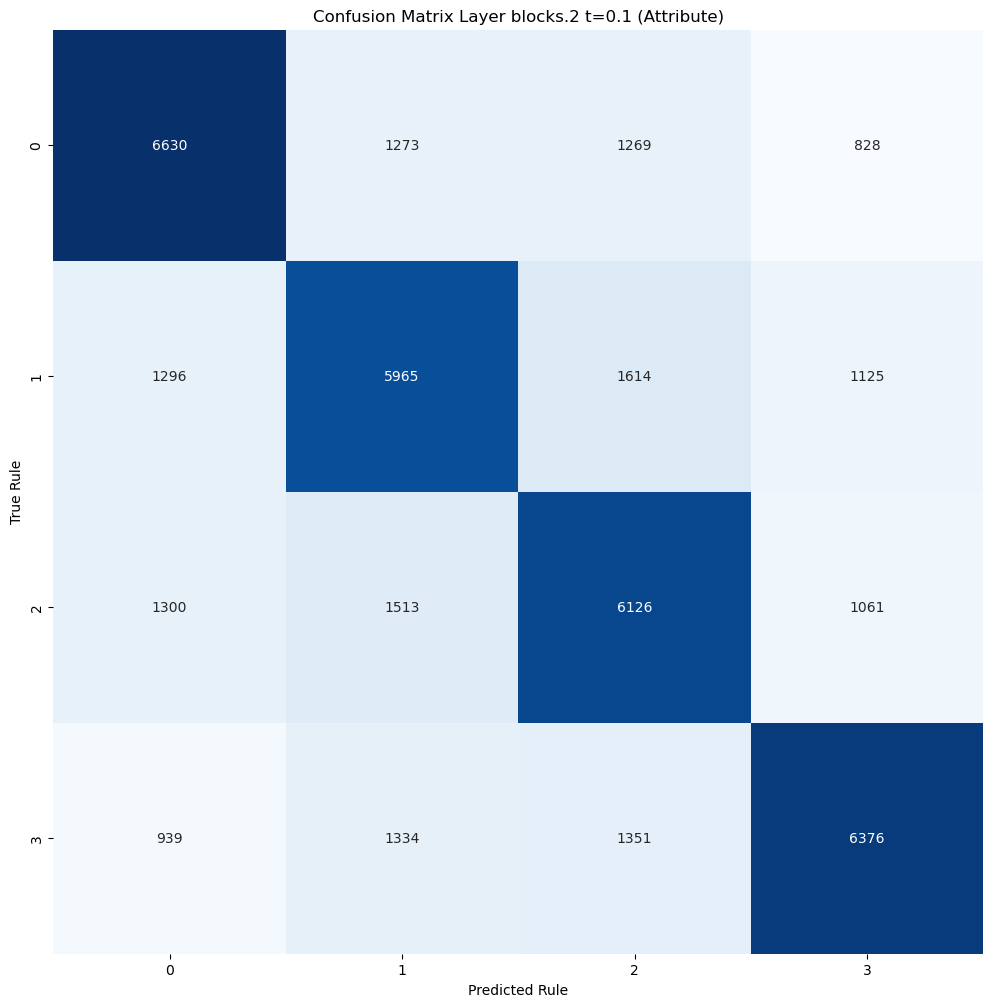

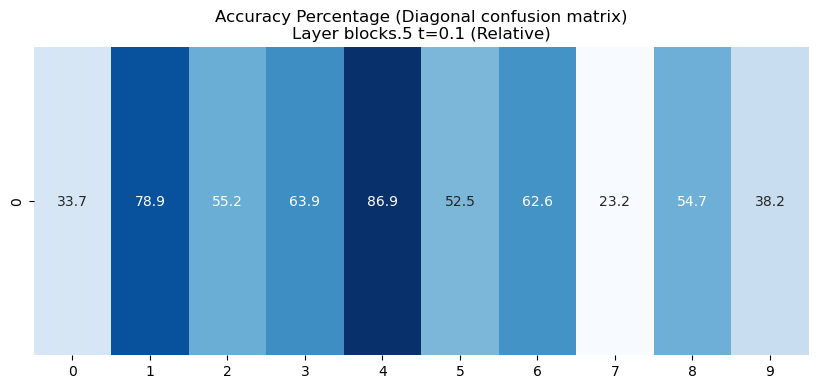

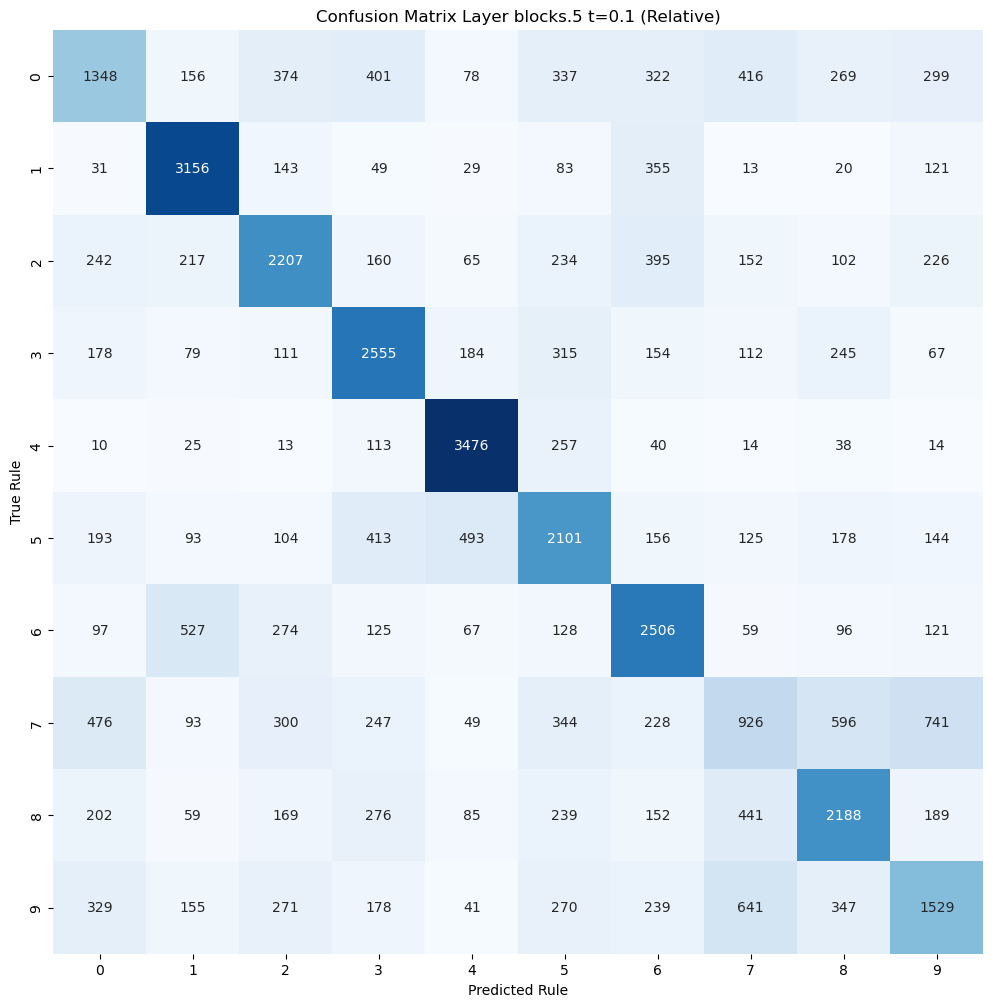

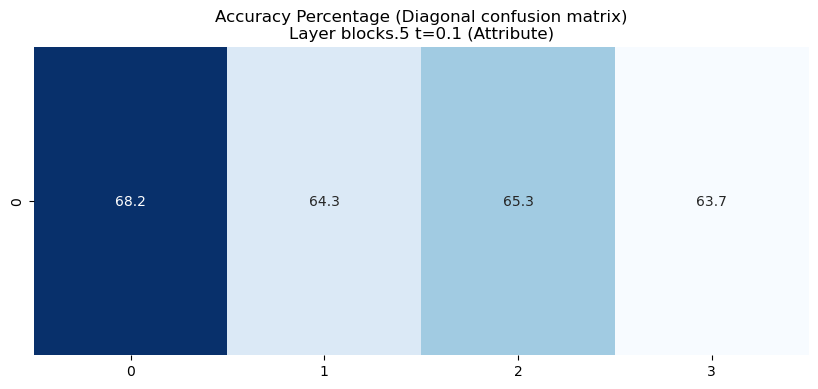

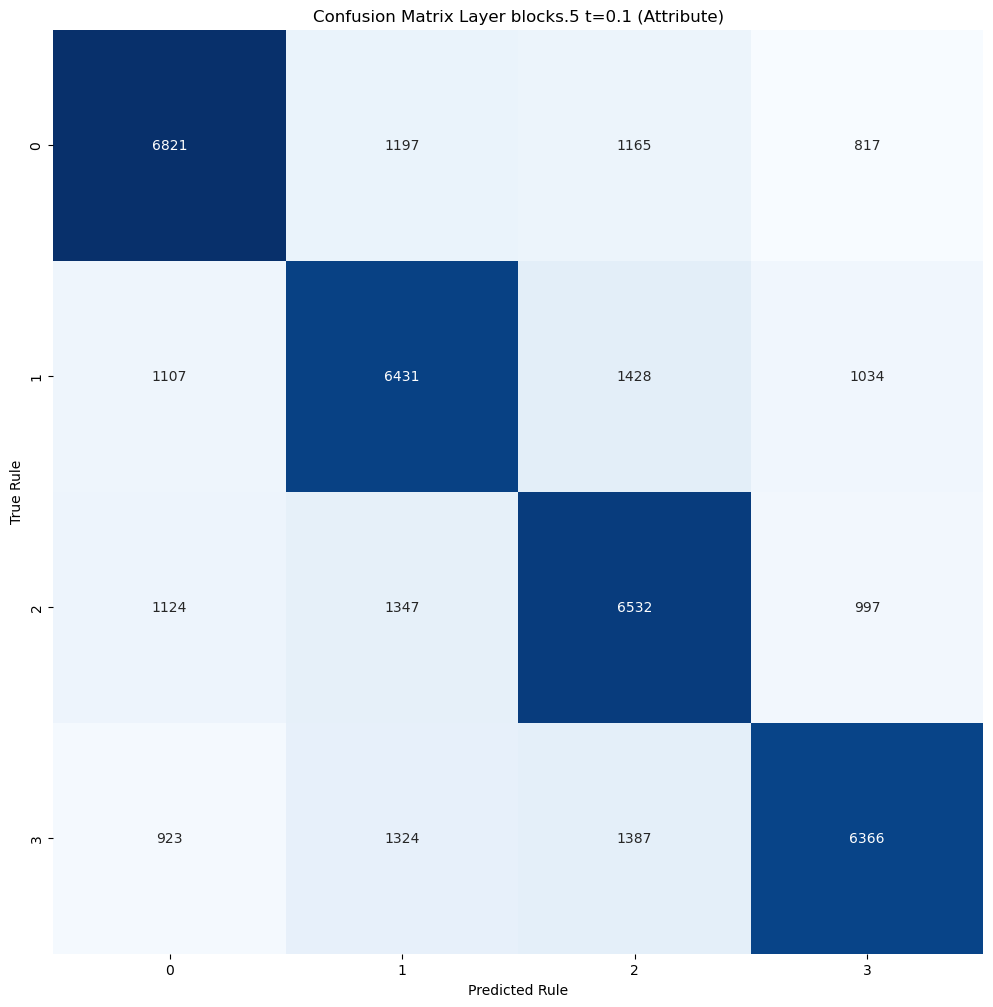

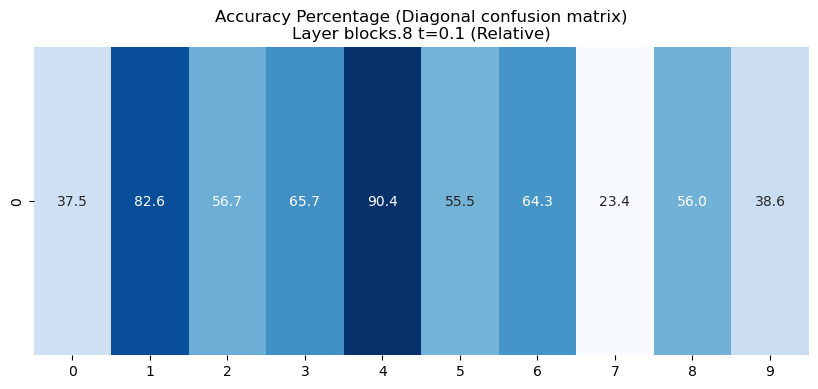

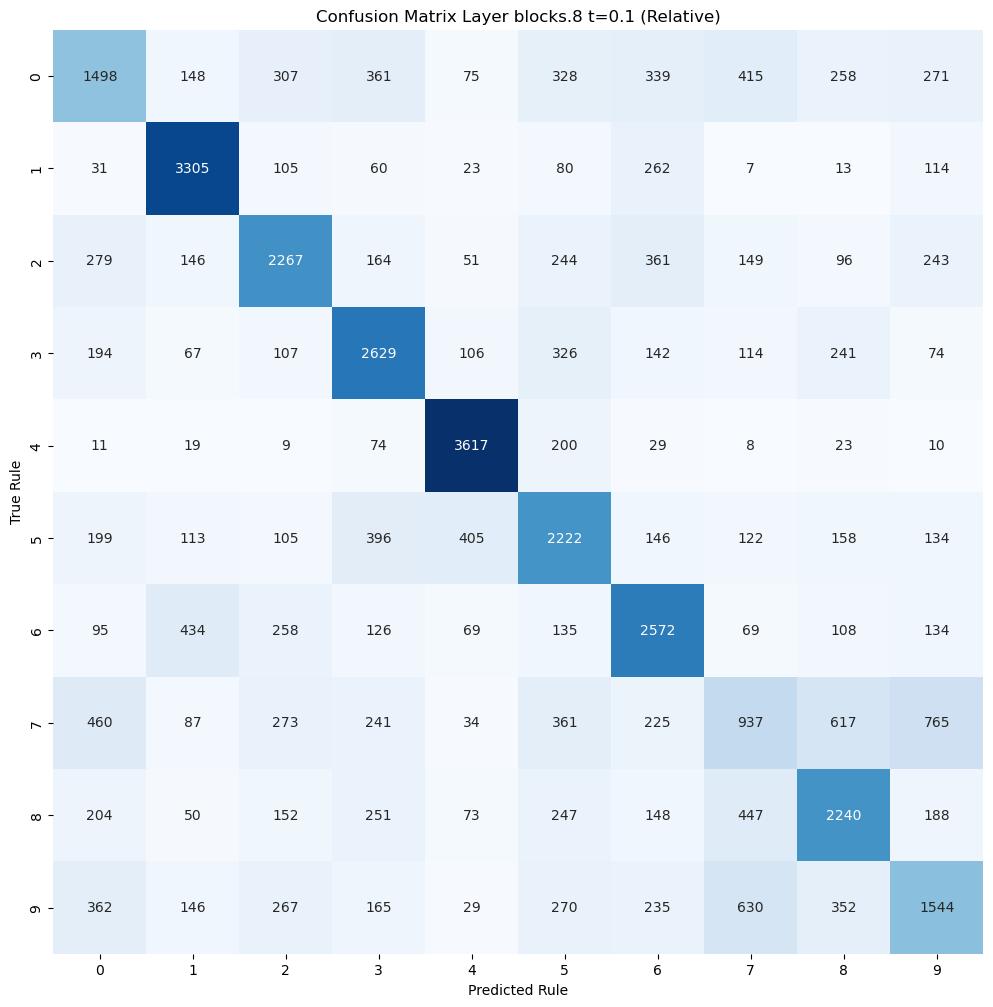

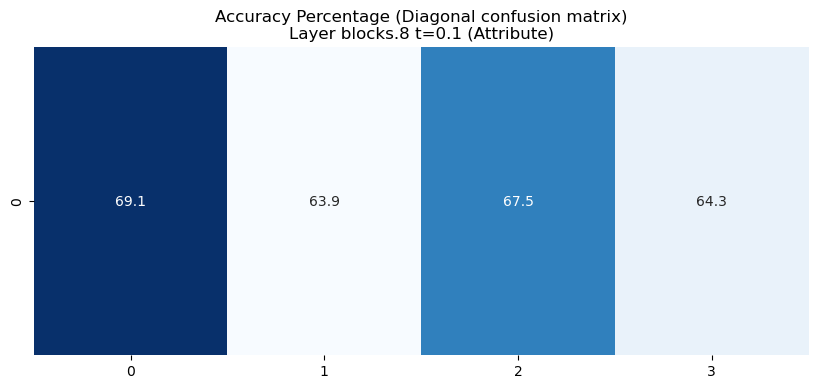

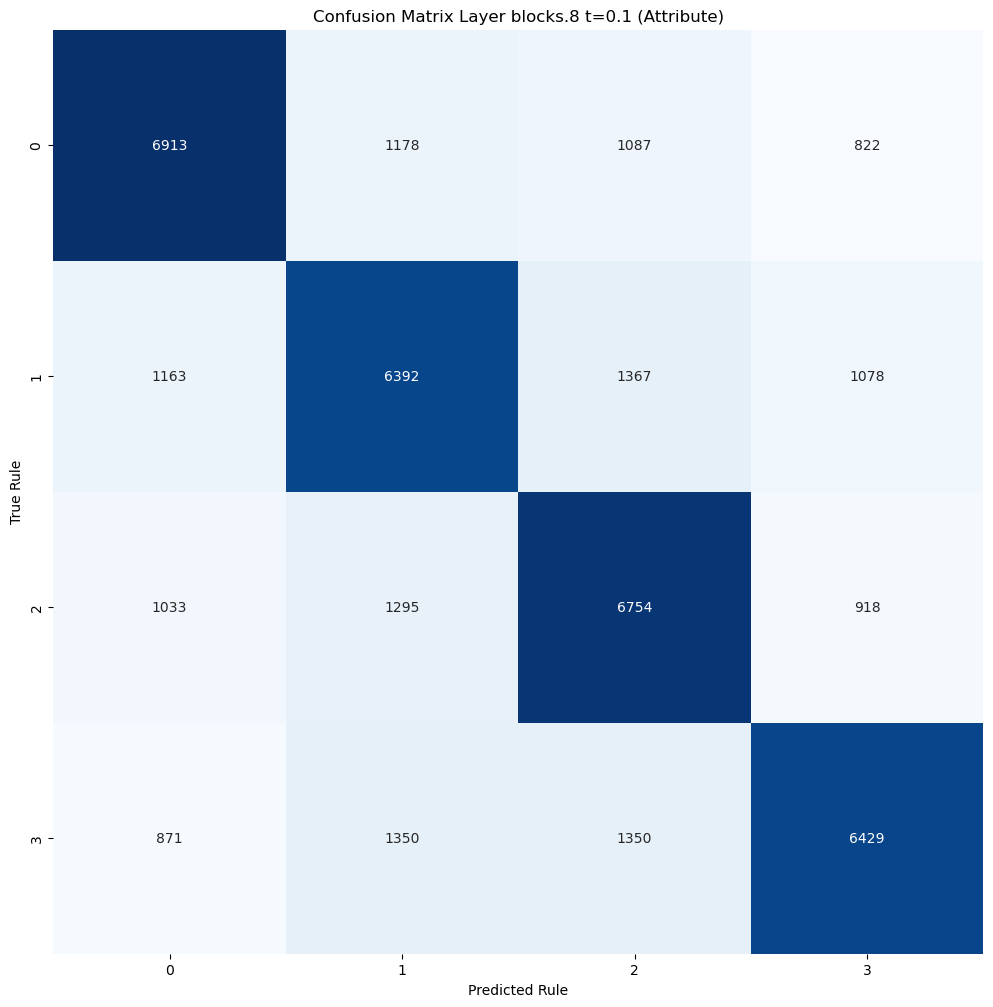

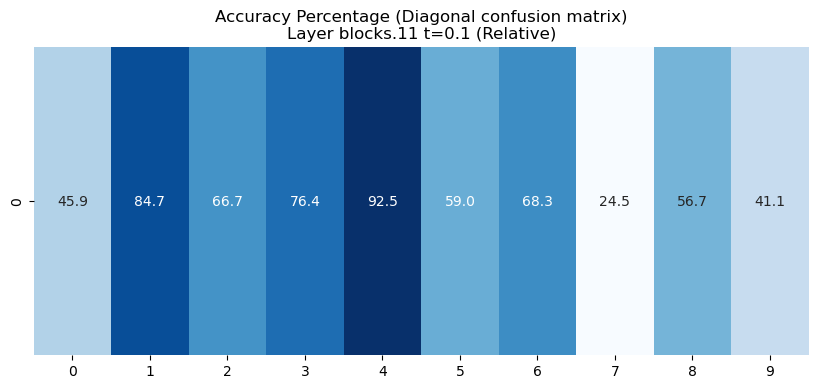

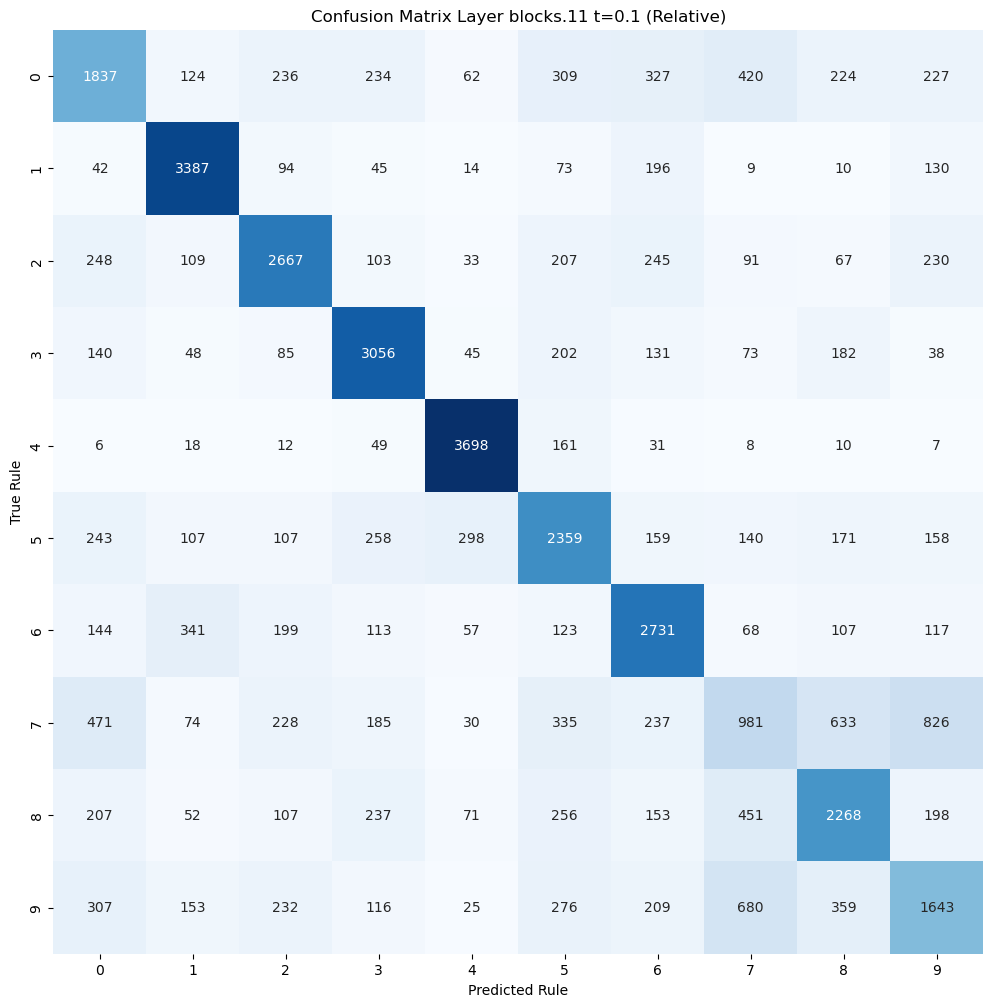

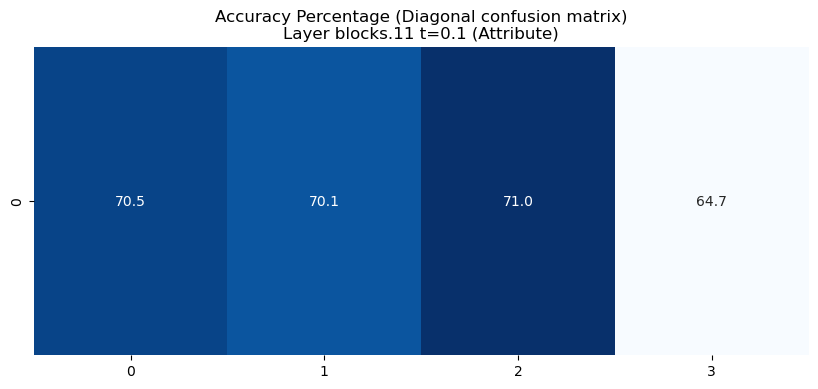

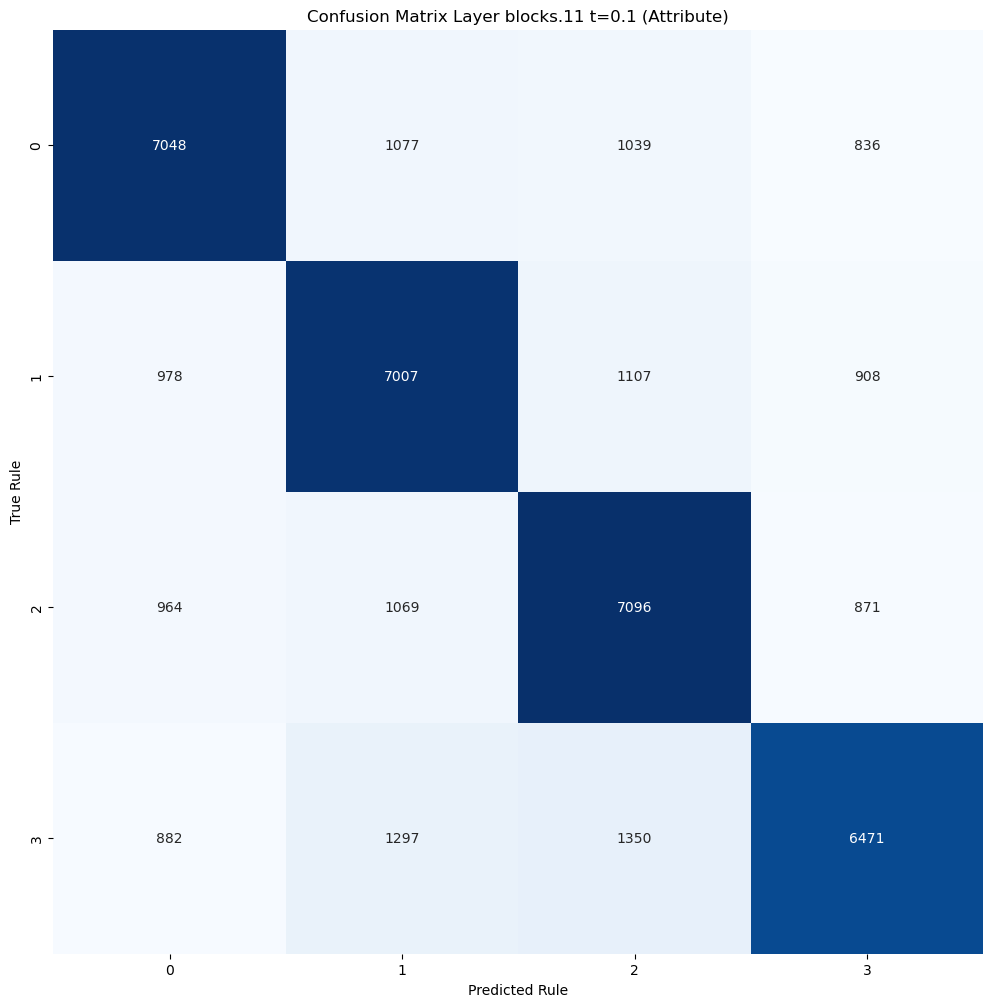

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
t_scalar = 0.1
for t_scalar in [0.1]:#[0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC1024.pkl"), "rb"))
    for key in results_col.keys():
        pred_cls = results_col[key]['pred_cls'].cpu()
        # cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        # visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar}")
        cm_rel = confusion_matrix(y_true=y_test % 10, y_pred=pred_cls % 10, )
        visualize_cm_default(cm_rel, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar} (Relative)")
        cm_attr = confusion_matrix(y_true=y_test // 10, y_pred=pred_cls // 10, )
        visualize_cm_default(cm_attr, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar} (Attribute)")

In [13]:
y_test % 10


tensor([0, 0, 0,  ..., 9, 9, 9])

In [ ]:
9 * 9 * 3

243